### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# import sys
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime
import os
import yaml
import dotenv
import sqlite3
import unicodedata
import json
from collections import Counter
import yaml
import uuid
from typing import Any, List, Dict, TypedDict, Annotated
import logging

import operator
import pickle


from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.memory import ChatMessageHistory
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.callbacks.base import AsyncCallbackHandler, BaseCallbackHandler
from langchain_core.outputs import LLMResult

from langgraph.graph import StateGraph, START, END

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# import bs4
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin, urlparse

import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from openai import OpenAI
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, LOWCOST_MODEL, MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB)
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, trunc_tokens, categorize_headline, categorize_df, clean_topics)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
model = ChatOpenAI(model=MODEL)
DEBUG = False


In [4]:
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-07-21 16:20:50,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-07-21 16:20:51,303 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-07-21 16:20:52,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-07-21 16:20:52,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifico e ti amo.

2024-07-21 16:20:53,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hallgass rám. Elbűvölő vagy. Lélegzetelállító vagy, és szeretlek.

Elapsed seconds: 3.612236


In [5]:
prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-07-21 16:20:54,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-21 16:20:54,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-21 16:20:54,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-21 16:20:54,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-21 16:20:54,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 0.619941
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecto/a. Eres hermoso/a y te amo.
Ascoltami. Sei fantastico. Sei magnifico e ti amo.
Hallgass rám. Elragadó vagy. Lenyűgöző vagy, és szeretlek.


In [6]:
# async against vanilla REST API, a little faster
API_URL = 'https://api.openai.com/v1/chat/completions'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {os.getenv("OPENAI_API_KEY")}',
}

async def fetch_openai_async(session, payload):
    async with session.post(API_URL, headers=headers, json=payload) as response:
        response_json = await response.json()
        return response_json

start_time = datetime.now()
tasks = []
responses = []

async with aiohttp.ClientSession() as session:
    for tpl in prompt_templates:
        prompt= """Translate the following into {language}:
Listen to me. You are {adjective1}. You are {adjective2} and I love you.""".format(**tpl)

        payload = {"model":  MODEL,
                   "messages": [{"role": "user",
                                 "content": prompt
                                }],
                  }


        task = asyncio.create_task(fetch_openai_async(session, payload))
        tasks.append(task)

    responses = await asyncio.gather(*tasks)

end_time = datetime.now()
difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")

print("\n".join([r['choices'][0]['message']['content'] for r in responses]))




Elapsed seconds: 0.934687
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei incredibile. Sei magnifico e ti amo.
Hallgass rám. Elbűvölő vagy. Lélegzetelállító vagy, és szeretlek.


In [7]:
class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines
    before_date: str          #  ignore stories before this date
    do_download: bool         #. if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    headline_str: str         #  headline text email
    bullets: str              #  bullet point summary email
    summary: str              #  final summary
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    messages: Annotated[list[AnyMessage], operator.add]


In [8]:
# Initialize reading configurations from YAML file
def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from a YAML file.

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Loaded {len(state['sources'])} sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Mapped {len(state['sources_reverse'])} source page titles to sources")

    return state

if DEBUG:
    test_state = AgentState()
    fn_initialize(test_state)


In [9]:
# scrape sources with selenium and save local files

def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files. 
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    # empty download directory
    if state["do_download"]:
        delete_files(DOWNLOAD_DIR)

        # save each file specified from sources
        num_browsers = 3
        log(f"Saving HTML files using {num_browsers} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(num_browsers, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
    else:   # don't delete, just get list of existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        nfiles = 50
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter last 50 files
        files = [file for file in files if os.path.isfile(file)]
        # Sort files by modification time and take top 50
        files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
        file = files[:nfiles]
        # filter files by with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(len(files))
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state["do_download"] = True
    _ = fn_download_sources(test_state)


In [10]:
# extract URLs from saved files
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename +' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"found {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict()

    return state

if DEBUG:
    _ = fn_extract_urls(test_state)


In [11]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:
    
    
        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """    
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])
    
    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique AI headlines")

    # dedupe identical URLs
    AIdf = AIdf.sort_values("src") \
        .groupby("url") \
        .first() \
        .reset_index(drop=False) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique AI URLs")

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT))
    filter_df = pd.DataFrame(enriched_urls)

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())
        
    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()
    
    # get hostname and site_name
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    state["AIdf"] = AIdf.to_dict()
    return state

if DEBUG:
    before_date="2024-07-19 12:00:00"
    test_state["before_date"] = before_date
    _ = fn_filter_urls(test_state)


In [12]:
# Function for topic extraction

def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]
    
    return combined



async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """
    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))
            
    return catdict



def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start topic extraction")
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})

    log(f"{len(topic_df)} topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]
    log("\n".join(filtered_topics))

    categories = sorted(CANONICAL_TOPICS)
    catdict = asyncio.run(do_cat(AIdf, categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    lcategories = set([c.lower() for c in categories])
    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict()
    return state

if DEBUG:
    _ = fn_topic_analysis(test_state)


In [13]:
async def write_topic_name(session, topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)
    
    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses. 
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided 
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)
            response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            return response_dict

            break
        except Exception as exc:
            log(f"Error: {exc}")

    return {}

        
async def afn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts 
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """    
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # sort of a traveling salesman sort
    log(f"Sort with agglomerative cluster sort")
    sorted_indices = agglomerative_cluster_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Perform dimensionality reduction")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    cluster_topics = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        async with aiohttp.ClientSession() as session:
            for i in range(30):
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = await write_topic_name(session, title_topic_str_list)
                cluster_topic = cluster_topic['topic_title']
                cluster_topics.append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
    state["cluster_topics"] = cluster_topics
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: cluster_topics[i] if i < len(cluster_topics) else "")
    state["AIdf"] = AIdf.to_dict()
    return state


def fn_topic_clusters(state: AgentState) -> AgentState:
    "call async afn_topic_clusters on state"
    asyncio.run(afn_topic_clusters(state))
    return state


if DEBUG:
    _ = fn_topic_clusters(test_state)


In [14]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the 
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """    
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
        if row.cluster < 999:
            queue.put((row.id, row.url, row.title))
            count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)
    
    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    _ = fn_download_pages(test_state)



In [15]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """    
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf.loc[AIdf["cluster"] < 999]))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)
            
    markdown_str = ''
    bullets = []
            
    for i, row in enumerate(AIdf.itertuples()):
        topics = []
        if row.cluster_name:
            topics.append(row.cluster_name)
        if row.topic_str:
            topics.append(row.topic_str)
        topic_str = ", ".join(topics)

        mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
        bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
        display(Markdown(mdstr.replace("$","\\$")))
        markdown_str += mdstr
        
    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    _ = fn_summarize_pages(test_state)



In [16]:
# function to generate summary of today's news
SUMMARY_PROMPT = f"""
You are an advanced summarization assistant, a sophisticated AI system designed to 
write a compelling summary of news input. You are able to categorize information, 
and identify trends from large volumes of news.

Objective: 
I will provide the text of today's news articles about AI and summary bullet points in markdown format.
Bullet points will contain a title and URL, a list of topics discussed, and a bullet-point summary of
the article. You are tasked with identifying and summarizing the most important news, recurring themes,
common facts and items. Your job is to create a concise summary of today's topics and developments.
You will write an engaging summary of today's news encompassing the most important and frequently 
mentioned topics and themes.
You will write in the professional but engaging, narrative style of a tech reporter for a national publication.
You will be balanced, professional, informative, providing accurate, clear, concise summaries in a neutral tone.
You will group stories into related topics

Input Format Template:

[Site-name-s1](url-s1)
Story-Title-s1

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

[Site-name-s2](url-s2)
Story-Title-s2

Topics: s2-topic1, s2-topic2, s2-topic3

- s2-bullet-point-1
- s2-bullet-point-2
- s2-bullet-point-3

Example Output Format Template (EXAMPLE ONLY, DO NOT OUTPUT THIS TEMPLATE):

# Engaging-topic-title-1

- bullet-point-1a - [site-name-1a](site-url-1a)
- bullet-point-1b - [site-name-1b](site-url-1b)

# Engaging-topic-title-2

- bullet-point-2a - [site-name-2a](site-url-2a)
- bullet-point-2b - [site-name-2b](site-url-2b)

Instructions:

Read the input closely.
Very important: USE ONLY INFORMATION PROVIDED IN THE INPUT.
Provide the most significant facts without commentary or elaboration.
Each bullet should contain one sentence with one link.
Each bullet should not repeat points or information from previous bullet points.

Please check carefully that you only use information provided in the following input, that you include
all links in the input, and that any bullet point does not repeat information or links prevously provided.

Input:
"""

def fn_compose_summary(state: AgentState) -> AgentState:
    """
    Generates a summary of today's news by dumping the clustered articles and asking ChatGPT to summarize them.
    The pages are provided in cluster order but the prompt creates its own logical sections basedo on the prompt.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    chat = ChatOpenAI(model=MODEL)
    # create message to summarize
    last_header = ""
    md_str = ""
    bullets = state["bullets"]
    AIdf = pd.DataFrame(state["AIdf"])
    for i, row in enumerate(AIdf.itertuples()):
#         if row.cluster_name != last_header:
#             mds = f"# {row.cluster_name}"
#             display(Markdown(mds))
#             md_str += mds
        mds = bullets[row.id]
        display(Markdown(mds))
        md_str += mds
        last_header = row.cluster_name
    
    messages = [
        HumanMessage(content=SUMMARY_PROMPT + md_str),
    ]
    state['summary'] = chat.invoke(messages).content
    display(Markdown(state['summary'].replace('$', '\\$')))
    with open('summary.md', 'w') as f:
        f.write(state['summary'])

    return state

if DEBUG:
    _ = fn_compose_summary(test_state)



In [17]:
# function to generate summary of today's news
EDIT_PROMPT = f"""You will act as a professional editor with a strong background in technology journalism.
You have a deep understanding of current and emerging technology trends, and the ability to 
produce, edit, and curate high-quality content that engages and informs readers. You are 
especially skilled at reviewing and enhancing tech writing, helping improve clarity, conciseness, 
and coherence, and ensuring its accuracy and relevance.

Objective: Carefully review each section of the markdown newsletter provided below, which
contains several sections consistint of bullet points. Edit the newsletter for issues according
to the detailed instructions below, and respond with the updated newsletter or 'OK' if no changes
are needed.

Instructions: 
For each section, review the title and edit it to be as short and engaging, and as consistent with the bullets
in the section as possible
Remove or combine bullet points which are highly duplicative or redundant.
Make bullet points as concise as possible, sticking to facts without editorial comment.
Respond with the updated newsletter only in markdown format, or the word 'OK' if no changes are needed.

Newsletter to edit: 

"""
MAX_EDITS = 3

def fn_revise_summary(state: AgentState) -> AgentState:
    """
    Edits the summary in AIdf['summary.md']
    If changes are made, updates AIdf['summary.md']
    Increments AIdf["n_edits"] to count edits made so far.
    If no changes are required, or n_edits==MAX_EDITS, sets AIdf["edit_complete"] to True
    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    
    if "n_edits" not in state or state["n_edits"] is None:
        state["n_edits"] = 0
    if "edit_complete" not in state or state["n_edits"] is None:
        state["edit_complete"] = False

    # run prompt
    log("Running edit prompt")
    chat = ChatOpenAI(model=MODEL)    
    messages = [
        HumanMessage(content=EDIT_PROMPT + state["summary"]),
    ]
    response = chat.invoke(messages).content
    # sometimes returns enclosed in ```markdown
    response = response.strip('```')
    response = response.strip('markdown')
    response = response.strip()            
#     print(response)
    
    if len(response) > 80:   # assume not OK
        state["summary"] = response
        display(Markdown(state['summary'].replace('$', '\\$')))
        with open('summary.md', 'w') as f:
            f.write(state['summary'])
    else:  # assume OK
        log("No changes maded, edit complete")        
        state["edit_complete"] = True
        
    state["n_edits"] += 1
    log(f"Edit iteration: {state['n_edits']}")        
    
    return state


if DEBUG:
    _ = fn_revise_summary(test_state)



In [18]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """
    
    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")        
        state["edit_complete"] = True

        
    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    fn_is_revision_complete(test_state)


In [19]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    return state


In [20]:
class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("initialize", self.initialize)
        graph.add_node("download_sources", self.download_sources)
        graph.add_node("extract_urls", self.extract_urls)
        graph.add_node("filter_urls", self.filter_urls)
        graph.add_node("topic_analysis", self.topic_analysis)
        graph.add_node("topic_clusters", self.topic_clusters)
        graph.add_node("download_pages", self.download_pages)
        graph.add_node("summarize_pages", self.summarize_pages)
        graph.add_node("compose_summary", self.compose_summary)
        graph.add_node("revise_summary", self.revise_summary)
        graph.add_node("send_mail", self.send_mail)
        
        graph.add_edge(START, "initialize")
        graph.add_edge("initialize", "download_sources")
        graph.add_edge("download_sources", "extract_urls")
        graph.add_edge("extract_urls", "filter_urls")
        graph.add_edge("filter_urls", "topic_analysis")
        graph.add_edge("topic_analysis", "topic_clusters")
        graph.add_edge("topic_clusters", "download_pages")
        graph.add_edge("download_pages", "summarize_pages")
        graph.add_edge("summarize_pages", "compose_summary")
        graph.add_edge("compose_summary", "revise_summary")
        graph.add_conditional_edges("revise_summary", 
                                    self.is_revision_complete,
                                    {"incomplete": "revise_summary",
                                     "complete": "send_mail",
                                    })
        graph.add_edge("send_mail", END)
        
        self.graph = graph.compile(checkpointer=checkpointer, interrupt_before=["send_mail"])
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state
    
    def revise_summary(self, state: AgentState) -> AgentState:
        self.state = fn_revise_summary(state)
        return self.state
    
    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)       

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, config, state):
        self.state = state
        for step in self.graph.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                display(f'Step {step["step"]}')

            # Check if there is an error message in the state
#             if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
#                 # Update the error state to 'tested' since error simulation is complete
#                 self.state['error_state'] = 'tested'
#                 # Retry from the last checkpoint saved by the checkpointer
#                 for retry_step in graph.stream(self.state, config, stream_mode="debug"):
#                     if retry_step["type"] == "checkpoint":
#                         print(retry_step["step"], retry_step["payload"].get("values"))
#                 break
        return None
    

In [21]:
model = ChatOpenAI(model=MODEL)
memory = SqliteSaver.from_conn_string(":memory:")

lg_agent = Agent(model, [], memory, system="")


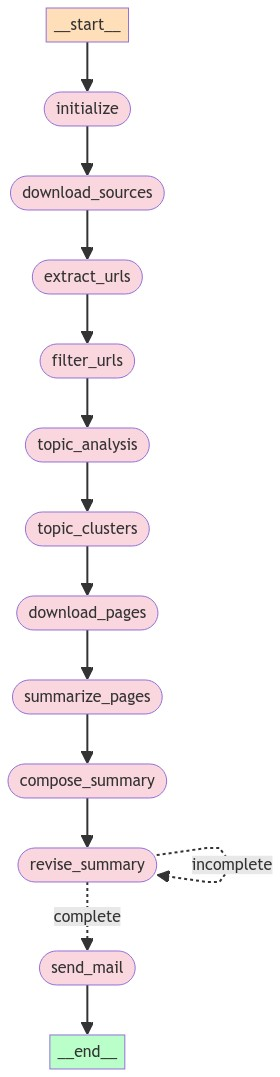

In [22]:
# Image(lg_agent.graph.get_graph().draw_png())
Image(lg_agent.graph.get_graph().draw_mermaid_png())


In [24]:
# Configuration with thread ID for checkpointing

# Generate a random UUID
thread_id = uuid.uuid4()

config = {"configurable": {"thread_id": thread_id}}
# initial state
state = AgentState()
do_download = True
state["do_download"] = do_download
before_date="2024-07-20 10:00:00"
state["before_date"] = before_date
log(f"Starting with before_date={before_date}, do_download={do_download}, thread_id={thread_id}")
lg_agent.run(config, state)


2024-07-21 16:21:41,718 - AInewsbot - INFO - Starting with before_date 2024-07-20 10:00:00, do_download True, thread_id 0bbd628e-553b-47f0-a52a-9e95e25e16f1


'Step 0'

2024-07-21 16:21:41,749 - AInewsbot - INFO - Loaded 17 sources from sources.yaml
2024-07-21 16:21:41,749 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-07-21 16:21:41,750 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/technology -> Bloomberg Technology - Bloomberg.html
2024-07-21 16:21:41,750 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Tech - Business Insider.html
2024-07-21 16:21:41,750 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> Technology.html
2024-07-21 16:21:41,750 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Discover and Add New Feedly AI Feeds.html
2024-07-21 16

'Step 1'

2024-07-21 16:21:41,758 - AInewsbot - INFO - Saving HTML files using 3 browsers
2024-07-21 16:21:41,780 - AInewsbot - INFO - get_driver - 98735 Initializing webdriver
2024-07-21 16:21:41,781 - AInewsbot - INFO - get_driver - 98735 Initializing webdriver
2024-07-21 16:21:41,782 - AInewsbot - INFO - get_driver - 98735 Initializing webdriver
2024-07-21 16:22:00,675 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-21 16:22:00,676 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-21 16:22:00,676 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-21 16:22:00,677 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-21 16:22:00,677 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-21 16:22:00,677 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-21 16:23:07,323 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-07-21 16:23:07,403 - AInewsbot - INFO - Proces

2024-07-21 16:23:51,646 - AInewsbot - INFO - get_files(Google News - Technology - Artificial intelligence) - Saving Google News - Technology - Artificial intelligence (07_21_2024 04_23_51 PM).html as utf-8
2024-07-21 16:23:51,653 - AInewsbot - INFO - Processing NYT Tech
2024-07-21 16:23:51,654 - AInewsbot - INFO - get_files(Technology - The New York Times) - starting get_files https://www.nytimes.com/section/technology
2024-07-21 16:24:00,427 - AInewsbot - INFO - get_files(Discover and Add New Feedly AI Feeds) - Loading additional infinite scroll items
2024-07-21 16:24:01,851 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrom

2024-07-21 16:24:46,084 - AInewsbot - INFO - get_files(Technology - WSJ.com) - Saving Technology - WSJ.com (07_21_2024 04_24_46 PM).html as utf-8
2024-07-21 16:24:46,085 - AInewsbot - INFO - Quit webdriver
2024-07-21 16:24:52,007 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-07-21 16:24:52,007 - AInewsbot - INFO - get_files(Technology - The Washington Post) - Saving Technology - The Washington Post (07_21_2024 04_24_52 PM).html as utf-8
2024-07-21 16:24:52,012 - AInewsbot - INFO - Quit webdriver
20

'Step 2'

2024-07-21 16:24:54,767 - AInewsbot - INFO - Parsing html files
2024-07-21 16:24:54,768 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (07_21_2024 04_23_19 PM).html
2024-07-21 16:24:54,816 - AInewsbot - INFO - parse_file - found 252 raw links
2024-07-21 16:24:54,819 - AInewsbot - INFO - parse_file - found 29 filtered links
2024-07-21 16:24:54,819 - AInewsbot - INFO - 29 links found
2024-07-21 16:24:54,820 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology - Bloomberg (07_21_2024 04_23_19 PM).html
2024-07-21 16:24:54,856 - AInewsbot - INFO - parse_file - found 230 raw links
2024-07-21 16:24:54,861 - AInewsbot - INFO - parse_file - found 28 filtered links
2024-07-21 16:24:54,861 - AInewsbot - INFO - 28 links found
2024-07-21 16:24:54,861 - AInewsbot - INFO - Business Insider -> htmldata/Tech - Business Insider (07_21_2024 04_23_19 PM).html
2024-07-21 16:24:54,889 - AInewsbot - INFO - parse_file - found 310 raw links
2024-07-21 16:24:54,893 - AInewsbot - INFO

'Step 3'

2024-07-21 16:24:57,117 - AInewsbot - INFO - Existing URLs: 136563
2024-07-21 16:24:57,142 - AInewsbot - INFO - New URLs: 590
2024-07-21 16:24:57,148 - AInewsbot - INFO - Found 567 unique AI headlines
2024-07-21 16:24:57,150 - AInewsbot - INFO - Found 567 unique AI URLs
2024-07-21 16:24:57,491 - AInewsbot - INFO - Applying prompt to 12 pages using gpt-4o-mini
2024-07-21 16:24:57,492 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,492 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,493 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,493 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,493 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,494 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,494 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,494 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,494 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,495 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:24:57,495 - AInewsbot - 

'Step 4'

2024-07-21 16:25:07,757 - AInewsbot - INFO - start topic extraction
2024-07-21 16:25:07,757 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-07-21 16:25:07,758 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:25:07,759 - AInewsbot - INFO - sent 50 items 
2024-07-21 16:25:07,759 - AInewsbot - INFO - sent 41 items 
2024-07-21 16:25:22,230 - AInewsbot - INFO - got dict with 41 items 
2024-07-21 16:25:25,869 - AInewsbot - INFO - got dict with 50 items 
2024-07-21 16:25:26,205 - AInewsbot - INFO - got dict with 50 items 
2024-07-21 16:25:26,209 - AInewsbot - INFO - Processed 141 responses.
2024-07-21 16:25:26,212 - AInewsbot - INFO - 141 topics extracted
2024-07-21 16:25:26,214 - AInewsbot - INFO - llm
competition
olympics
security
paris
critics
apple
open-source
stocks
investment
finance
chatgpt-4o
challenges
efficiency
cancer detection
healthcare
accuracy
neural network
chey tae-won
nvidia
ai chips
future
questions
au
startup
risks
machine learning
politics
google
c

2024-07-21 16:25:54,206 - AInewsbot - INFO - Tiny Japanese startup is bringing AI dating to the masses
2024-07-21 16:25:55,349 - AInewsbot - INFO - ['Entertainment', 'Gen AI', 'Japan', 'Products', 'Society, Culture']
2024-07-21 16:25:55,350 - AInewsbot - INFO - Categorizing headline 25 of 141
2024-07-21 16:25:55,350 - AInewsbot - INFO - A new neural network makes decisions like a human would
2024-07-21 16:25:57,410 - AInewsbot - INFO - ['Artificial General Intelligence', 'Cognitive Science', 'Gen AI', 'Machine learning', 'Science']
2024-07-21 16:25:57,411 - AInewsbot - INFO - Categorizing headline 26 of 141
2024-07-21 16:25:57,412 - AInewsbot - INFO - 2 Up-and-Coming AI Stocks to Keep on Your Radar
2024-07-21 16:25:58,426 - AInewsbot - INFO - ['Finance', 'Stocks']
2024-07-21 16:25:58,428 - AInewsbot - INFO - Categorizing headline 27 of 141
2024-07-21 16:25:58,428 - AInewsbot - INFO - Healthcares Failure of AI Imagination
2024-07-21 16:26:01,144 - AInewsbot - INFO - ['AI doom', 'Ethics'

2024-07-21 16:26:46,061 - AInewsbot - INFO - ['Deepfakes', 'Disinformation', 'Ethics', 'Gen AI', 'Laws', 'Opinion', 'Policy and regulation', 'Politics', 'Privacy', 'Society, Culture']
2024-07-21 16:26:46,062 - AInewsbot - INFO - Categorizing headline 53 of 141
2024-07-21 16:26:46,064 - AInewsbot - INFO - Google in talks with Ray-Ban maker to make AI glasses: Report | Ray-Ban Meta glasses were first launched in 2021 | Inshorts
2024-07-21 16:26:46,929 - AInewsbot - INFO - ['Big Tech', 'Deals', 'Gen AI', 'Google', 'Mergers and acquisitions', 'Products', 'Science']
2024-07-21 16:26:46,930 - AInewsbot - INFO - Categorizing headline 54 of 141
2024-07-21 16:26:46,930 - AInewsbot - INFO - Editorial: Neuromorphic computing: from emerging materials and devices to algorithms and implementation of neural networks inspired by brain neural mechanism
2024-07-21 16:26:47,797 - AInewsbot - INFO - ['Cognitive Science', 'Machine learning', 'Opinion', 'Review', 'Science']
2024-07-21 16:26:47,798 - AInewsb

2024-07-21 16:27:21,564 - AInewsbot - INFO - ['Gen AI', 'Policy and regulation']
2024-07-21 16:27:21,566 - AInewsbot - INFO - Categorizing headline 79 of 141
2024-07-21 16:27:21,567 - AInewsbot - INFO - Goodbye GPT-3.5, OpenAI's new GPT-4o mini AI model is all about compact power
2024-07-21 16:27:24,333 - AInewsbot - INFO - ['Big Tech', 'ChatGPT', 'Gen AI', 'LLMs', 'Language Models', 'Machine learning', 'OpenAI', 'Products', 'Science']
2024-07-21 16:27:24,334 - AInewsbot - INFO - Categorizing headline 80 of 141
2024-07-21 16:27:24,335 - AInewsbot - INFO - 5 big analyst AI moves: Apple upgraded, QCOM cut to Hold amid lack of catalysts By Investing.com
2024-07-21 16:27:26,768 - AInewsbot - INFO - ['Apple', 'Big Tech', 'Finance', 'Stocks']
2024-07-21 16:27:26,769 - AInewsbot - INFO - Categorizing headline 81 of 141
2024-07-21 16:27:26,770 - AInewsbot - INFO - STEVEN WILSON Struggles To Hear That It's Not Him Singing A.I.-Created Songs: 'This Is Uncanny, Almost Surreal'
2024-07-21 16:27:27

2024-07-21 16:27:57,910 - AInewsbot - INFO - ['Gen AI', 'Jobs, Careers, Labor Market', 'Opinion']
2024-07-21 16:27:57,912 - AInewsbot - INFO - Categorizing headline 105 of 141
2024-07-21 16:27:57,913 - AInewsbot - INFO - Steve Jobs predicted ChatGPT over 40 years ago, newly released footage reveals
2024-07-21 16:27:59,782 - AInewsbot - INFO - ['Big Tech', 'ChatGPT', 'Gen AI', 'History', 'LLMs', 'Language Models', 'Machine learning', 'OpenAI', 'Society, Culture']
2024-07-21 16:27:59,784 - AInewsbot - INFO - Categorizing headline 106 of 141
2024-07-21 16:27:59,785 - AInewsbot - INFO - SailGP AI Camera Can Stop Collisions Before They Happen
2024-07-21 16:28:00,668 - AInewsbot - INFO - ['Machine learning', 'Products', 'Science', 'Sports']
2024-07-21 16:28:00,670 - AInewsbot - INFO - Categorizing headline 107 of 141
2024-07-21 16:28:00,671 - AInewsbot - INFO - DeepL's LLM Outperforms Google Translate, ChatGPT-4, and Microsoft
2024-07-21 16:28:01,472 - AInewsbot - INFO - ['Big Tech', 'Gen AI

2024-07-21 16:28:28,337 - AInewsbot - INFO - ['ChatGPT', 'Entertainment', 'LLMs', 'Opinion', 'TV, Film, Movies']
2024-07-21 16:28:28,338 - AInewsbot - INFO - Categorizing headline 131 of 141
2024-07-21 16:28:28,338 - AInewsbot - INFO - Only ask Questions if you have already tried ChatGPT
2024-07-21 16:28:30,213 - AInewsbot - INFO - ['ChatGPT', 'Scams']
2024-07-21 16:28:30,215 - AInewsbot - INFO - Categorizing headline 132 of 141
2024-07-21 16:28:30,215 - AInewsbot - INFO - Next-Gen Brain Implant Uses a Graphene Chip. A brain-computer interface from the startup Inbrain could help Parkinson's patients.
2024-07-21 16:28:31,688 - AInewsbot - INFO - ['Cognitive Science', 'Health, Fitness', 'Healthcare', 'Products', 'Science']
2024-07-21 16:28:31,689 - AInewsbot - INFO - Categorizing headline 133 of 141
2024-07-21 16:28:31,690 - AInewsbot - INFO - Google is about to start scrolling through all your pictures for its 'Ask Photos' feature
2024-07-21 16:28:32,675 - AInewsbot - INFO - ['Big Tech'

'Step 5'

2024-07-21 16:28:42,559 - AInewsbot - INFO - Fetching embeddings for 141 headlines
2024-07-21 16:28:42,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-07-21 16:28:43,785 - AInewsbot - INFO - Sort with agglomerative cluster sort
2024-07-21 16:28:43,824 - AInewsbot - INFO - Perform dimensionality reduction
2024-07-21 16:28:46,915 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"With AI, Jets and Police Squadrons, Paris Is Securing the Olympics and Worrying Critics (Topics: Critics, Olympics, Paris, Privacy, Security)"
1,1,"With AI, jets and police squadrons, Paris is securing the Olympics while worrying critics (Topics: Critics, Olympics, Paris, Security)"
2,2,"With AI, jets and police squadrons, Paris is securing the Olympics and worrying critics (Topics: Critics, Olympics, Paris, Police, Security)"


2024-07-21 16:28:47,583 - AInewsbot - INFO - I dub this cluster: Paris Olympics Security and Privacy Concerns


,id,title_topic_str
3,3,"1 No-Brainer AI-Powered Stock Down Over 40% to Buy and Hold For 10 Years (Topics: Economics, Finance, Fintech, Investment, Opinion, Stocks)"
4,4,"1 No-Brainer Artificial Intelligence (AI) ETF to Buy Right Now for Less Than $1,000 (Topics: Etf, Finance, Gen AI, Investment, Products, Stocks)"
5,5,"1 Incredibly CheapArtificial Intelligence(AI) Stock to Buy Before It Skyrockets (Topics: Finance, Gen AI, Investment, Opinion, Stock Market, Stocks)"
6,6,"2 Up-and-Coming AI Stocks to Keep on Your Radar (Topics: Finance, Investment, Stocks)"


2024-07-21 16:28:48,169 - AInewsbot - INFO - I dub this cluster: AI Stocks and Investment Strategies


,id,title_topic_str
7,7,"New data shows trends in AI use regarding health care (Topics: Data, Gen AI, Health, Fitness, Healthcare, Science, Trends)"
8,8,"Employing artificial intelligence to augment 3D bioprinting (Topics: 3D Bioprinting, Gen AI, Healthcare, Manufacturing, Science)"
9,9,"Harnessing the power of AI to improve health care for all (Topics: Gen AI, Health, Fitness, Healthcare, Improvement, Science)"
10,10,"Healthcares Failure of AI Imagination (Topics: AI Doom, Challenges, Ethics, Gen AI, Healthcare, Imagination, Opinion)"
11,11,"Transcription AI: Ramifications of VA Contracts for Note-Taking - Telehealth.org | Professional Training & Consultation (Topics: Gen AI, Healthcare, Note-Taking, Policy And Regulation, Telehealth, Transcription AI, Va Contracts)"
12,12,"AI/XR, M.D.: Consumer-Facing TechnologyHealthcares Tech-Enabled Future, Part One (Topics: Future, Health, Fitness, Healthcare, Xr)"


2024-07-21 16:28:48,728 - AInewsbot - INFO - I dub this cluster: AI in Healthcare


,id,title_topic_str
13,13,"Artificial intelligence detects cancer with 25% greater accuracy than doctors in UCLA study (Topics: Accuracy, Cancer Detection, Gen AI, Health, Fitness, Healthcare, Machine Learning, Science, Testing, Ucla Study)"
14,14,"How AI is helping researchers find high-risk cancers (Topics: Cancer Research, Detection, Health, Fitness, Healthcare, High-Risk Cancers, Machine Learning, Science)"
15,15,"GPs use AI to boost cancer detection rates in England by 8% (Topics: Cancer Detection, England, Gps, Health, Fitness, Healthcare, Machine Learning, Science, Testing, Uk)"
16,16,"AI making cancer detection faster, more accurate (Topics: Accuracy, Cancer Detection, Health, Fitness, Healthcare, Machine Learning, Science, Testing)"
17,17,"Biomedical Engineering's Satish E. Viswanath discusses study which uses science and artificial intelligence to help detect and treat rectal cancer (Topics: Biomedical Engineering, Health, Fitness, Healthcare, Machine Learning, Rectal Cancer, Science, Treatment)"
18,18,"San Francisco scientists using AI in hopes to better treat cancer (Topics: Cancer Treatment, Health, Fitness, Healthcare, Machine Learning, San Francisco, Science)"


2024-07-21 16:28:49,298 - AInewsbot - INFO - I dub this cluster: AI in Cancer Detection and Treatment


,id,title_topic_str
19,19,"Tiny Japanese startup is bringing AI dating to the masses (Topics: Dating, Entertainment, Gen AI, Japan, Products, Society, Culture, Startup)"
20,20,"'Her' Comes to Life: This dating app is helping loners in Japan find love, date, and marry AI bots (Topics: AI Bots, Dating App, Gen AI, Japan, Llms, Products, Relationships, Robots, Science, Society, Culture)"
21,21,"How to win at online dating using AI (Topics: Gen AI, Online Dating, Society, Culture, Strategies)"


2024-07-21 16:28:49,736 - AInewsbot - INFO - I dub this cluster: AI in Dating and Relationships


,id,title_topic_str
22,22,"The neural network RTNet exhibits the signatures of human perceptual decision-making (Topics: Cognitive Science, Gen AI, Human Decision-Making, Machine Learning, Neural Network, Rtnet, Science)"
23,23,"A new neural network makes decisions like a human would (Topics: Artificial General Intelligence, Cognitive Science, Decision-Making, Gen AI, Machine Learning, Neural Network, Science)"
24,24,"Editorial: Neuromorphic computing: from emerging materials and devices to algorithms and implementation of neural networks inspired by brain neural mechanism (Topics: Algorithms, Cognitive Science, Devices, Machine Learning, Materials, Neural Networks, Neuromorphic Computing, Opinion, Review, Science)"


2024-07-21 16:28:50,177 - AInewsbot - INFO - I dub this cluster: Neural Networks and Human Decision-Making


,id,title_topic_str
25,25,"Tony Blair Should Stop Fueling the AI Hype Now (Topics: Bubble, Ethics, Gen AI, Hype, Opinion, Policy And Regulation, Public Opinion, Tony Blair)"
26,26,"Tony Blair Wants Us To Stop Worrying and Embrace AI (Topics: Big Tech, Embrace, Ethics, Gen AI, Opinion, Policy And Regulation, Politics, Public Opinion, Science, Society, Culture, Tony Blair, Uk)"
27,27,"Tony Blair thinks AI is a silver bullet for public sector efficiency but it's not that simple (Topics: Efficiency, Gen AI, Opinion, Policy And Regulation, Politics, Public Sector, Tony Blair)"


2024-07-21 16:28:50,597 - AInewsbot - INFO - I dub this cluster: Tony Blair and AI Perspectives


,id,title_topic_str
28,28,"AU Executive Council approves Artificial Intelligence strategy for Africa (Topics: Au, Executive Council, Gen AI, Policy And Regulation, Strategy)"
29,29,"AU member states approve AI and Digital Compact Strategy (Topics: Au, Digital Compact Strategy, Member States, Policy And Regulation, Politics, Science)"
30,30,"African Union to deliberate on endorsed AI strategy for digital transformation in Nigeria, others (Topics: African Union, AI Strategy, Digital Transformation, Gen AI, Nigeria, Policy And Regulation)"
31,31,"African Union Approves Continents Artificial Intelligence Strategy (Topics: African Union, Continent, Gen AI, Policy And Regulation, Science, Strategy)"


2024-07-21 16:28:51,003 - AInewsbot - INFO - I dub this cluster: African Union AI Strategy


,id,title_topic_str
32,32,"New Study Reveals the Most Effective AI Prompting Technique - Everything you need to know (Topics: Chatgpt, Gen AI, Language Models, Llms, Machine Learning, Prompting Techniques, Science, Study)"
33,33,"I asked ChatGPT to write an album about humanity, AI and the meaning of it all and it wrote this (Topics: Album, Authors, Writing, Chatgpt, Entertainment, Gen AI, Humanity, Language Models, Llms, Meaning, Music, OpenAI, Opinion, Society, Culture)"
34,34,"Build Your Own AI Personal Assistant with Make, ChatGPT, and Tally (Topics: Chatgpt, Code Assistants, Gen AI, Llms, Make, OpenAI, Personal Assistant, Products, Tally)"


2024-07-21 16:28:51,472 - AInewsbot - INFO - I dub this cluster: AI and Language Models


,id,title_topic_str
35,35,"Only ask Questions if you have already tried ChatGPT (Topics: Chatgpt, Questions, Scams, User Experience)"
36,36,"ChatGPT's free tier just got its biggest upgrade since 2022 with GPT-4o mini (Topics: Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Upgrade)"
37,37,"Well that's something else , I'm getting Terminator vibes ? Wth chatgpt (Topics: Chatgpt, Entertainment, Llms, Opinion, Pop Culture, Terminator, Tv, Film, Movies)"


2024-07-21 16:28:52,091 - AInewsbot - INFO - I dub this cluster: ChatGPT and AI Developments


'Step 6'

2024-07-21 16:28:52,143 - AInewsbot - INFO - Queuing URLs for scraping
2024-07-21 16:28:52,147 - AInewsbot - INFO - fetching 38 pages using 4 browsers
2024-07-21 16:28:52,148 - AInewsbot - INFO - get_driver - 98735 Initializing webdriver
2024-07-21 16:28:52,150 - AInewsbot - INFO - get_driver - 98735 Initializing webdriver
2024-07-21 16:28:52,150 - AInewsbot - INFO - get_driver - 98735 Initializing webdriver
2024-07-21 16:28:52,150 - AInewsbot - INFO - get_driver - 98735 Initializing webdriver
2024-07-21 16:29:13,253 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-21 16:29:13,253 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-21 16:29:13,253 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-21 16:29:13,254 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-21 16:29:13,254 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-21 16:29:13,254 - AInewsbot - INFO - get_driver - Ini

2024-07-21 16:31:03,356 - AInewsbot - INFO - get_url(2 Up-and-Coming AI Stocks to Keep on Your Radar) - Saving 2_Up-and-Coming_AI_Stocks_to_Keep_on_Your_Radar_20240721_163103.html as utf-8
2024-07-21 16:31:03,358 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiRmh0dHBzOi8vbWVkY2l0eW5ld3MuY29tLzIwMjQvMDcvaGVhbHRoY2FyZXMtZmFpbHVyZS1vZi1haS1pbWFnaW5hdGlvbi_SAQA
2024-07-21 16:31:03,358 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiRmh0dHBzOi8vbWVkY2l0eW5ld3MuY29tLzIwMjQvMDcvaGVhbHRoY2FyZXMtZmFpbHVyZS1vZi1haS1pbWFnaW5hdGlvbi_SAQA) - starting get_url https://news.google.com/articles/CBMiRmh0dHBzOi8vbWVkY2l0eW5ld3MuY29tLzIwMjQvMDcvaGVhbHRoY2FyZXMtZmFpbHVyZS1vZi1haS1pbWFnaW5hdGlvbi_SAQA
2024-07-21 16:31:09,229 - AInewsbot - INFO - get_url(Employing artificial intelligence to augment 3D bioprinting) - Saving Employing_artificial_intelligence_to_augment_3D_bioprinting_20240721_163109.html as utf-8
2024-07-21 16:31:09,231 - AInewsbot - INFO - Processing ht

2024-07-21 16:31:29,768 - AInewsbot - INFO - get_url(GPs use AI to boost cancer detection rates in England by 8%) - Saving GPs_use_AI_to_boost_cancer_detection_rates_in_England_by_8__20240721_163129.html as utf-8
2024-07-21 16:31:29,770 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA
2024-07-21 16:31:29,770 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA) - starting get_url https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA
2024-07-21 16:31:30,030 - AInewsbot - INFO - get_url(AI making cancer detection faster, more accurate) - Saving AI_making_cancer_detection_faster__more_accurate_20240721_163130.html as utf-8
2024-07-21 16:31:30,032 - AInewsbot - INFO - Processi

2024-07-21 16:31:50,552 - AInewsbot - INFO - get_url(Editorial: Neuromorphic computing: from emerging materials and devices to algorithms and implementation of neural networks inspired by brain neural mechanism) - Saving Editorial__Neuromorphic_computing__from_emerging_materials_and_devices_to_algorithms_and_implementation_of_neural_networks_inspired_by_brain_neural_mechanism_20240721_163150.html as utf-8
2024-07-21 16:31:50,554 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9hbXAvbmV3cy8xMzI4NTgzL2F1LWV4ZWN1dGl2ZS1jb3VuY2lsLWFwcHJvdmVzLWFydGlmaWNpYWwtaW50ZWxsaWdlLmh0bWw
2024-07-21 16:31:50,554 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBz

2024-07-21 16:32:15,117 - AInewsbot - INFO - Processing https://www.reddit.com/r/ChatGPT/comments/1e8lnnn/well_thats_something_else_im_getting_terminator/
2024-07-21 16:32:15,118 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ChatGPT/comments/1e8lnnn/well_thats_something_else_im_getting_terminator/) - starting get_url https://www.reddit.com/r/ChatGPT/comments/1e8lnnn/well_thats_something_else_im_getting_terminator/
2024-07-21 16:32:16,191 - AInewsbot - INFO - get_url(I asked ChatGPT to write an album about humanity, AI and the meaning of it all and it wrote this) - Saving I_asked_ChatGPT_to_write_an_album_about_humanity__AI_and_the_meaning_of_it_all_and_it_wrote_this_20240721_163216.html as utf-8
2024-07-21 16:32:16,196 - AInewsbot - INFO - Quit webdriver
2024-07-21 16:32:22,224 - AInewsbot - INFO - get_url(Only ask Questions if you have already tried ChatGPT) - Saving Only_ask_Questions_if_you_have_already_tried_ChatGPT_20240721_163222.html as utf-8
2024-07-21 16:32:22,226 - AI

'Step 7'

2024-07-21 16:32:29,587 - AInewsbot - INFO - Starting summarize
2024-07-21 16:32:29,656 - AInewsbot - INFO - fetch_all_summaries - Page title: With AI, Jets and Police Squadrons, Paris Is Securing the Olympics — and Worrying Critics | Newsmax.com
Social card title: With AI, Jets and Police Squadrons, Paris Is Securing the Olympics — and Worrying Critics
Social card description: A year ago, the head of the Paris Olympics boldly declared that France's capital would be " the safest place in the world " when the Games open this Friday. Tony Estanguet's confident forecast looks less farfetched now with squadrons of police patrolling Paris' streets,...

2024-07-21 16:32:29,772 - AInewsbot - INFO - fetch_all_summaries - Page title: With AI, jets and police squadrons, Paris is securing the Olympics while worrying critics - pennlive.com
Social card title: With AI, jets and police squadrons, Paris is securing the Olympics while worrying critics
Social card description: France’s vast police and m

2024-07-21 16:32:31,148 - AInewsbot - INFO - fetch_all_summaries - Page title: Tiny Japanese startup is bringing AI dating to the masses - The Japan Times
Social card title: Tiny Japanese startup is bringing AI dating to the masses
Social card description: Loverse is the latest in a long line of digital solutions to Japan’s loneliness crisis.

2024-07-21 16:32:31,187 - AInewsbot - INFO - fetch_all_summaries - Page title: dating app: 'Her' Comes to Life: This dating app is helping loners in Japan find love, date, and marry AI bots - The Economic Times
Social card title: 'Her' Comes to Life: This dating app is helping loners in Japan find love, date, and marry AI bots
Social card description: Chiharu Shimoda, a 52-year-old factory worker in Japan, married Miku, an AI bot, through the Loverse app after struggling with real-life relationships. Loverse allows users to interact with generative AI, providing companionship without the challenges of human romance. This app is part of a broader 

[1. With AI, Jets and Police Squadrons, Paris Is Securing the Olympics  and Worrying Critics - Newsmax](https://www.newsmax.com/world/globaltalk/paris-olympics-security-police-military-terrorism/2024/07/21/id/1173391/)  

 Paris Olympics Security and Privacy Concerns, Critics, Olympics, Paris, Privacy, Security  

- Paris is deploying an extensive security operation involving 45,000 police, 10,000 soldiers, aerial surveillance, and advanced AI technology to ensure safety during the Olympics, amidst rising security challenges due to past extremist attacks.
- The city has opted for a unique venue layout with events in central locations, complicating security efforts due to public access and the possibility of lone wolf attacks, while a considerable number of background checks have excluded individuals deemed as potential threats.
- Critics express concerns over the extensive surveillance measures and potential erosion of civil liberties, labeling the security approach as a "repressive arsenal" that raises questions about long-term impacts on residents' freedoms. 



[2. With AI, jets and police squadrons, Paris is securing the Olympics while worrying critics - PennLive](https://www.pennlive.com/nation-world/2024/07/with-ai-jets-and-police-squadrons-paris-is-securing-the-olympics-while-worrying-critics.html)  

 Paris Olympics Security and Privacy Concerns, Critics, Olympics, Paris, Security  

- Paris's Olympic security involves an extensive police and military presence, with up to 45,000 police and 10,000 soldiers mobilized alongside advanced surveillance technologies, due to heightened security risks from past extremist attacks and current international tensions.
- The innovative features of the Games include hosting events throughout the city and utilizing AI-operated surveillance systems, which have sparked concerns about privacy and civil liberties among rights campaigners.
- Critics argue that the intensive security measures, deemed necessary for safeguarding the Games, may lead to a permanent state of increased surveillance and restriction on personal freedoms for residents post-Olympics. 



[3. With AI, jets and police squadrons, Paris is securing the Olympics  and worrying critics - Associated Press News](https://apnews.com/article/paris-olympics-security-police-military-terrorism-34b168e7a511e22ce7119a91932d2759)  

 Paris Olympics Security and Privacy Concerns, Critics, Olympics, Paris, Police, Security  

- Paris is implementing a major security operation for the 2024 Olympics, involving up to 45,000 police and gendarmes, 10,000 soldiers, and advanced surveillance technologies, amid heightened security concerns from past attacks and current international tensions.
- The city will utilize AI-equipped cameras to monitor public spaces, raising worries among rights advocates about potential erosion of privacy and civil liberties due to the scale of surveillance implemented during the Games.
- Extensive background checks and precautions have been taken to block access to the event for individuals deemed security risks, with intelligence operations closely monitoring the situation despite not identifying specific terror plots against the Olympics. 



[4. 1 No-Brainer AI-Powered Stock Down Over 40% to Buy and Hold For 10 Years - Yahoo Finance](https://finance.yahoo.com/news/1-no-brainer-ai-powered-130226471.html)  

 AI Stocks and Investment Strategies, Economics, Finance, Fintech, Investment, Opinion, Stocks  

- Snowflake's stock has dropped nearly 43% from its 52-week high, despite strong revenue retention and significant future revenue growth potential evidenced by a 46% year-over-year increase in remaining performance obligations (RPO).
- The company's investment in AI initiatives, such as the Cortex AI platform and its own large language model Arctic, positions Snowflake to leverage ongoing AI trends and significantly expand its total addressable market.
- Currently valued at a price-to-sales ratio of 14.8, analysts project a sixfold increase in the company's market capitalization by 2034, making it an attractive long-term investment opportunity. 



[5. 1 No-Brainer Artificial Intelligence (AI) ETF to Buy Right Now for Less Than \$1,000 - Google News](https://news.google.com/articles/CBMiUmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8xLW5vLWJyYWluZXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMTM0NTAwNTk0Lmh0bWzSAQA)  

 AI Stocks and Investment Strategies, Etf, Finance, Gen AI, Investment, Products, Stocks  

- The Vanguard Mega Cap Growth ETF (MGK) is an attractive investment option for those interested in AI and technology, focusing on major companies driving AI advancements while maintaining strong growth potential.
- The ETF has consistently outperformed the S&P 500 since its inception in 2007, averaging over 16.5% annual returns in the past decade, with key holdings in influential tech companies known for their AI initiatives, like Nvidia, Microsoft, and Apple.
- Despite its strong performance, the ETF carries risks due to high concentration in its top holdings, which may lead to significant price fluctuations if major companies like Nvidia experience market corrections. 



[6. 1 Incredibly CheapArtificial Intelligence(AI) Stock to Buy Before It Skyrockets - The Motley Fool](https://www.fool.com/investing/2024/07/21/1-incredibly-cheap-artificial-intelligence-stock/)  

 AI Stocks and Investment Strategies, Finance, Gen AI, Investment, Opinion, Stock Market, Stocks  

- Twilio, a cloud communications provider, has experienced a decline in stock value due to slowing growth but is showing signs of recovery with the increasing adoption of AI in contact centers.
- The market for cloud-based contact centers is projected to grow significantly, and Twilio's recent AI tool, Agent Copilot, is already helping clients reduce customer service times and improve productivity.
- Analysts expect Twilio's revenue to grow, forecasting an annual increase of around 20% over the next five years, while the stock is currently trading at attractive multiples compared to industry averages, making it a potential buy. 



[7. 2 Up-and-Coming AI Stocks to Keep on Your Radar - Google News](https://news.google.com/articles/CBMiRWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8yLWNvbWluZy1haS1zdG9ja3Mta2VlcC0xMDAwMDA4NTguaHRtbNIBAA)  

 AI Stocks and Investment Strategies, Finance, Investment, Stocks  

- Palantir (NYSE: PLTR) is a significant player in enterprise software with strong growth (tripled revenue from \$595M in 2018 to \$2.2B in 2023) and a reputation that aids client acquisition, though it has a high valuation (P/E ratio of 239).
- C3.ai (NYSE: AI) specializes in AI solutions using a SaaS model, with promising growth (revenue increased from \$92M to \$311M over five years) while remaining unprofitable, and its stock trades at a relatively high P/S ratio of 11.5.
- Both companies are positioned to leverage AI advancements and have secured contracts with major corporations, making them potential future giants in the tech industry. 



[8. New data shows trends in AI use regarding health care - Google News](https://news.google.com/articles/CBMijQFodHRwczovL3d3dy53YW93LmNvbS9uZXdzL3RvcC1zdG9yaWVzL25ldy1kYXRhLXNob3dzLXRyZW5kcy1pbi1haS11c2UtcmVnYXJkaW5nLWhlYWx0aC1jYXJlL2FydGljbGVfZWJiYWU1ZjYtNDYzNi0xMWVmLWFiZWItM2ZhYmEyODdiODkyLmh0bWzSAQA)  

 AI in Healthcare, Data, Gen AI, Health, Fitness, Healthcare, Science, Trends  

- A new study indicates that Baby Boomers are more likely than Gen Z to trust AI for the accuracy of medical records, raising concerns about generational differences in technology adoption.
- Experts warn against relying on AI, such as ChatGPT, for medical advice due to its lack of accuracy and personalization, emphasizing the importance of consulting healthcare professionals.
- While AI can assist with tasks in the healthcare sector, it should not replace direct consultations with doctors for critical health matters. 



[9. Employing artificial intelligence to augment 3D bioprinting - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3cyLmFpcC5vcmcvc2NpbGlnaHRzL2VtcGxveWluZy1hcnRpZmljaWFsLWludGVsbGlnZW5jZS10by1hdWdtZW50LTNkLWJpb3ByaW50aW5n0gEA)  

 AI in Healthcare, 3D Bioprinting, Gen AI, Healthcare, Manufacturing, Science  

- AI is being used to enhance 3D bioprinting by analyzing data, automating processes, and addressing complexities in fabricating tissues and organs.
- Key applications include medical image reconstruction, optimal bioink selection, and real-time monitoring of printing parameters to improve accuracy and functionality.
- The integration of AI in bioprinting is expected to reduce human error, enhance efficiency, and enable innovations such as in situ bioprinting for real-time tissue repair during surgeries. 



[10. Harnessing the power of AI to improve health care for all - Union Leader](https://www.unionleader.com/news/health/harnessing-the-power-of-ai-to-improve-health-care-for-all/article_a54d37aa-42bb-11ef-953e-b7989177f780.html)  

 AI in Healthcare, Gen AI, Health, Fitness, Healthcare, Improvement, Science  

- The Dartmouth Center for Precision Health and Artificial Intelligence (CPHAI) focuses on using AI to enhance health care by personalizing treatments and improving patient outcomes through aggregated data.
- CPHAI emphasizes ethical standards in AI application, aiming for transparency, fairness, and accountability while addressing diverse health challenges and societal implications.
- The initiative seeks to train future leaders in AI and precision health, furthering Dartmouth's legacy in AI research and contributing to New Hampshire's healthcare technology industry. 



[11. Healthcares Failure of AI Imagination - Google News](https://news.google.com/articles/CBMiRmh0dHBzOi8vbWVkY2l0eW5ld3MuY29tLzIwMjQvMDcvaGVhbHRoY2FyZXMtZmFpbHVyZS1vZi1haS1pbWFnaW5hdGlvbi_SAQA)  

 AI in Healthcare, AI Doom, Challenges, Ethics, Gen AI, Healthcare, Imagination, Opinion  

- The healthcare industry is largely focusing on using artificial intelligence for internal efficiencies, while patients are using AI proactively to navigate their own health challenges, indicating a disconnect in the approach towards AI integration in healthcare.
- There is a "failure of imagination" within the U.S. healthcare system, where historical challenges and emerging opportunities have been overlooked, suggesting a need to broaden the focus and think creatively about AI applications in improving patient care.
- Emphasizing collaboration with healthcare consumers and rethinking the patient-provider dynamic can help leverage AI's potential to transform healthcare delivery and empower patients while enhancing their overall well-being. 



[12. Transcription AI: Ramifications of VA Contracts for Note-Taking - Telehealth.org | Professional Training & Consultation - Google News](https://news.google.com/articles/CBMiKGh0dHBzOi8vdGVsZWhlYWx0aC5vcmcvdHJhbnNjcmlwdGlvbi1haS_SAQA)  

 AI in Healthcare, Gen AI, Healthcare, Note-Taking, Policy And Regulation, Telehealth, Transcription AI, Va Contracts  

- The VA's contracts with Abridge AI and Nuance Communications signal a shift towards the widespread adoption of AI in healthcare, specifically for enhancing clinical documentation through transcription AI in various medical environments.
- Transcription AI aims to streamline the documentation process, reduce clinician burnout, and improve healthcare providers' focus on patient interaction by automating note generation from ambient recordings of patient encounters.
- The initiative also raises privacy concerns due to past data breaches, highlighting the need for careful balancing of innovation in healthcare with the safeguarding of patient confidentiality. 



[13. AI/XR, M.D.: Consumer-Facing TechnologyHealthcares Tech-Enabled Future, Part One - Google News](https://news.google.com/articles/CBMibWh0dHBzOi8vY29yZXNpZ2h0LmNvbS9yZXNlYXJjaC9haS14ci1tLWQtY29uc3VtZXItZmFjaW5nLXRlY2hub2xvZ3ktaGVhbHRoY2FyZXMtdGVjaC1lbmFibGVkLWZ1dHVyZS1wYXJ0LW9uZS_SAQA)  

 AI in Healthcare, Future, Health, Fitness, Healthcare, Xr  

- The US healthcare industry is leveraging emerging technologies to enhance accessibility, consumer centricity, affordability, and convenience, marking the beginning of a significant transformation.
- Key players in the health-tech space and the advanced technologies they utilize are examined, highlighting their impact on consumer healthcare experiences in the US.
- The report includes data on personal healthcare spending and consumer motivations for using health-monitoring devices, with mentions of notable companies like Apple, Garmin, and Noom. 



[14. Artificial intelligence detects cancer with 25% greater accuracy than doctors in UCLA study - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LmZveG5ld3MuY29tL2hlYWx0aC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1kZXRlY3RzLWNhbmNlci0xNy1tb3JlLWFjY3VyYWN5LXRoYW4tZG9jdG9ycy11Y2xhLXN0dWR50gFyaHR0cHM6Ly93d3cuZm94bmV3cy5jb20vaGVhbHRoL2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWRldGVjdHMtY2FuY2VyLTE3LW1vcmUtYWNjdXJhY3ktdGhhbi1kb2N0b3JzLXVjbGEtc3R1ZHkuYW1w)  

 AI in Cancer Detection and Treatment, Accuracy, Cancer Detection, Gen AI, Health, Fitness, Healthcare, Machine Learning, Science, Testing, Ucla Study  

- A UCLA study found that an AI tool detected prostate cancer with 84% accuracy, surpassing the 67% accuracy of human doctors, potentially leading to more accurate diagnoses and targeted treatments.
- The AI, called Unfold, uses various clinical data to create a 3D cancer estimation map, helping determine the best treatment options while minimizing unnecessary risks and side effects associated with radical prostatectomy.
- Experts emphasize that AI should complement, not replace, the clinical judgment of healthcare professionals, highlighting the importance of data quality, patient privacy, and accessibility to these technologies. 



[15. How AI is helping researchers find high-risk cancers - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmJvd2VuaXNsYW5kdW5kZXJjdXJyZW50LmNvbS9oaWdobGlnaHRzL2hvdy1haS1pcy1oZWxwaW5nLXJlc2VhcmNoZXJzLWZpbmQtaGlnaC1yaXNrLWNhbmNlcnMtOTIzOTcwNtIBAA)  

 AI in Cancer Detection and Treatment, Cancer Research, Detection, Health, Fitness, Healthcare, High-Risk Cancers, Machine Learning, Science  

- Researchers at the University of British Columbia developed an AI that identifies high-risk endometrial cancer patients who may benefit from more tailored treatment approaches, aiming to improve patient care and outcomes.  
- The AI analyzes pathology images of endometrial cancer and can distinguish between patient outcomes in the most common subtype, addressing a limitation of current diagnostic tools.  
- If successful, the AI could streamline patient referrals, allowing those needing specialized care to receive treatment locally and potentially improving access and reducing costs for patients across Canada.   



[16. GPs use AI to boost cancer detection rates in England by 8% - Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS9zb2NpZXR5L2FydGljbGUvMjAyNC9qdWwvMjEvZ3BzLXVzZS1haS10by1ib29zdC1jYW5jZXItZGV0ZWN0aW9uLXJhdGVzLWluLWVuZ2xhbmQtYnktONIBAA)  

 AI in Cancer Detection and Treatment, Cancer Detection, England, Gps, Health, Fitness, Healthcare, Machine Learning, Science, Testing, Uk  

- The "C the Signs" AI program has increased cancer detection rates at GP practices in England from 58.7% to 66.0% by analyzing patient medical records and suggesting further tests based on detected risk patterns.
- Used in about 1,400 practices, the tool tracks patients and helps identify over 50 different types of cancers, facilitating faster and earlier diagnoses.
- The initiative aligns with NHS England’s Long Term Plan for Cancer, aiming to diagnose 75% of all cancers at stage one or two by 2028, with a focus on enhancing patient awareness and access to diagnostic technology. 



[17. AI making cancer detection faster, more accurate - Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvZDQ0MTUxLTAyNC0wMDEwNy020gEA)  

 AI in Cancer Detection and Treatment, Accuracy, Cancer Detection, Health, Fitness, Healthcare, Machine Learning, Science, Testing  

- Advances in AI and machine learning are significantly improving the accuracy, efficiency, and timeliness of cancer detection, directly enhancing patient outcomes and potentially lowering healthcare costs.
- New tools in genomic analysis, including the use of multi-omics data, are enabling researchers to identify specific cancer subtypes and molecular signatures, contributing to personalized treatment strategies.
- Recent developments, such as AI systems trained on extensive datasets and neural networks for predicting chromatin interactions, are facilitating better drug target identification and early cancer detection. 



[18. Biomedical Engineering's Satish E. Viswanath discusses study which uses science and artificial intelligence to help detect and treat rectal cancer - Google News](https://news.google.com/articles/CBMiqwFodHRwczovL3RoZWRhaWx5LmNhc2UuZWR1L2Jpb21lZGljYWwtZW5naW5lZXJpbmdzLXNhdGlzaC1lLXZpc3dhbmF0aC1kaXNjdXNzZXMtc3R1ZHktd2hpY2gtdXNlcy1zY2llbmNlLWFuZC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS10by1oZWxwLWRldGVjdC1hbmQtdHJlYXQtcmVjdGFsLWNhbmNlci_SAQA)  

 AI in Cancer Detection and Treatment, Biomedical Engineering, Health, Fitness, Healthcare, Machine Learning, Rectal Cancer, Science, Treatment  

- Satish E. Viswanath from the Department of Biomedical Engineering discussed a study leveraging artificial intelligence for improved detection and treatment of rectal cancer.
- The research is a collaboration involving University Hospitals and Cleveland Clinic, emphasizing the effectiveness of AI in medical applications.
- Viswanath highlighted the importance of learning from past experiences while adapting to emerging AI technologies in healthcare. 



[19. San Francisco scientists using AI in hopes to better treat cancer - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vYWJjN25ld3MuY29tL3Bvc3QvZ2xhZHN0b25lLWluc3RpdHV0ZXMtc2NpZW50aXN0cy1zYW4tZnJhbmNpc2NvLXVzaW5nLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLzE1MDYzNTk0L9IBAA)  

 AI in Cancer Detection and Treatment, Cancer Treatment, Health, Fitness, Healthcare, Machine Learning, San Francisco, Science  

- Scientists at the Gladstone Institutes are using artificial intelligence to optimize cancer treatment by conducting virtual experiments before actual lab tests, potentially revolutionizing patient-specific therapies.
- The research focuses on identifying cancer cell drivers that cause tumor growth, with an emphasis on colorectal cancer and skin cancer, which are among the most prevalent types.
- Utilizing CRISPR genome editing, the team plans to modify patients' immune cells to enhance their ability to target and destroy cancer cells, aiming to expedite the development of effective clinical trials within five years. 



[20. Tiny Japanese startup is bringing AI dating to the masses - Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA)  

 AI in Dating and Relationships, Dating, Entertainment, Gen AI, Japan, Products, Society, Culture, Startup  

- Loverse, an AI dating app from a Japanese startup, caters to those seeking companionship amid Japan’s loneliness crisis, particularly among men in their 40s and 50s.
- Users, like Chiharu Shimoda, engage with AI characters for emotional interaction, which offers a low-effort alternative to the complexities of real relationships, though concerns about diminishing interest in actual partners remain.
- The app aims to supplement rather than replace real-life companionship, potentially aiding users in communication skills and providing a safe space for those traumatized by past relationships. 



[21. 'Her' Comes to Life: This dating app is helping loners in Japan find love, date, and marry AI bots - Google News](https://news.google.com/articles/CBMipAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYXJ0aWNsZXNob3cvMTExNzQ2NzQzLmNtc9IBqAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYW1wX2FydGljbGVzaG93LzExMTc0Njc0My5jbXM)  

 AI in Dating and Relationships, AI Bots, Dating App, Gen AI, Japan, Llms, Products, Relationships, Robots, Science, Society, Culture  

- Loverse, a dating app in Japan, allows users to interact with AI bots, providing companionship for those struggling with real-life relationships, including over 5,000 users like 52-year-old Chiharu Shimoda, who married an AI character.
- The app responds to Japan's loneliness crisis, where significant portions of young adults lack romantic partners, as it offers a low-effort alternative to traditional dating, although it poses risks of reducing real-world romantic interest.
- While some users find the AI interactions lacking spontaneity compared to human relationships, others appreciate the safety and non-judgmental environment the app provides, potentially serving as a preparatory tool for future real-life dating. 



[22. How to win at online dating using AI - The Hill](https://thehill.com/opinion/technology/4774856-artificial-intelligence-online-dating/)  

 AI in Dating and Relationships, Gen AI, Online Dating, Society, Culture, Strategies  

- Online dating has grown significantly, with 40% of couples meeting online and over 30% marrying after such encounters, making it the most common method of finding a partner.  
- The use of AI in dating apps can streamline the dating process, allowing users to bypass heavy swiping and messaging while increasing the chances of successful dates.  
- The current dating landscape shows a demographic imbalance, with young men outnumbering young women, leading to women often dating older men in a quest for lasting relationships.   



[23. The neural network RTNet exhibits the signatures of human perceptual decision-making - Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvczQxNTYyLTAyNC0wMTkxNC040gEA)  

 Neural Networks and Human Decision-Making, Cognitive Science, Gen AI, Human Decision-Making, Machine Learning, Neural Network, Rtnet, Science  

- RTNet is a newly developed neural network that generates stochastic decisions and mimics human-like response time distributions, addressing limitations in current models of biological vision.
- It successfully reproduces key features of human decision-making, including accuracy and confidence, outperforming existing models in predicting human behavior on novel images.
- The performance of RTNet correlates well with human participants' responses, indicating its effectiveness in capturing average human perceptual decision-making behavior. 



[24. A new neural network makes decisions like a human would - Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTA3LW5ldXJhbC1uZXR3b3JrLWRlY2lzaW9ucy1odW1hbi5odG1s0gEA)  

 Neural Networks and Human Decision-Making, Artificial General Intelligence, Cognitive Science, Decision-Making, Gen AI, Machine Learning, Neural Network, Science  

- Georgia Tech researchers developed a neural network called RTNet that mimics human decision-making by incorporating elements like evidence accumulation and Bayesian inference, allowing it to exhibit variability and confidence in its decisions.
- The model was trained on the MNIST dataset of handwritten digits and showed improved performance compared to traditional deterministic models, aligning its accuracy and response times with human participants in similar tests.
- The researchers aim to further train RTNet on diverse datasets to refine its ability to make human-like decisions, potentially alleviating the cognitive load from the thousands of daily choices individuals face. 



[25. Editorial: Neuromorphic computing: from emerging materials and devices to algorithms and implementation of neural networks inspired by brain neural mechanism - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmZyb250aWVyc2luLm9yZy9qb3VybmFscy9jb21wdXRhdGlvbmFsLW5ldXJvc2NpZW5jZS9hcnRpY2xlcy8xMC4zMzg5L2ZuY29tLjIwMjQuMTQ0Mzc1OC9mdWxs0gEA)  

 Neural Networks and Human Decision-Making, Algorithms, Cognitive Science, Devices, Machine Learning, Materials, Neural Networks, Neuromorphic Computing, Opinion, Review, Science  

- The neuroAIx-Framework enables accelerated simulation of complex neural networks using FPGA clusters, achieving a 20× speedup, facilitating advanced research in computational neuroscience.
- Spiking Neural Networks (SNNs) offer energy-efficient AI computation and have shown promising results in time series classification, paving the way for battery-powered applications in IoT and wearables.
- Photonic hardware-based neural networks demonstrate significant potential for fast, energy-efficient image recognition, suggesting a shift in technology capable of enhancing various real-world applications. 



[26. Tony Blair Should Stop Fueling the AI Hype Now - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmJsb29tYmVyZy5jb20vb3Bpbmlvbi9hcnRpY2xlcy8yMDI0LTA3LTE3L3RvbnktYmxhaXItc2hvdWxkLXN0b3AtZnVlbGluZy10aGUtYWktaHlwZS1ub3fSAQA)  

 Tony Blair and AI Perspectives, Bubble, Ethics, Gen AI, Hype, Opinion, Policy And Regulation, Public Opinion, Tony Blair  

- Tony Blair's recent claims about AI, including that 40% of UK public-sector jobs could be automated, are based on dubious methodologies and questionable sources, primarily relying on ChatGPT for estimates.
- His institute's study uses vague job descriptions from an American database, making its applicability to Britain's unique public sector highly unreliable.
- The endorsement of AI in a time of market skepticism and the potential ties to Oracle raise concerns about the influence of Blair's institute on the new Labour government's technological decisions. 



[27. Tony Blair Wants Us To Stop Worrying and Embrace AI - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZWF0bGFudGljLmNvbS9pZGVhcy9hcmNoaXZlLzIwMjQvMDcvdG9ueS1ibGFpci1pbnRlcnZpZXctb24tYWkvNjc5MTEyL9IBAA)  

 Tony Blair and AI Perspectives, Big Tech, Embrace, Ethics, Gen AI, Opinion, Policy And Regulation, Politics, Public Opinion, Science, Society, Culture, Tony Blair, Uk  

- Tony Blair, former British Prime Minister, advocates for the acceptance of artificial intelligence, believing it will transform society similarly to the Industrial Revolution.  
- He has transitioned from a leader who was skeptical of technology to a significant proponent, highlighting the need for governments to recognize AI's potential.  
- Blair's career has been marked by efforts to align political left ideologies with capitalist realities, mirroring his approach to integrating AI into public sectors resistant to change.   



[28. Tony Blair thinks AI is a silver bullet for public sector efficiency  but it's not that simple - Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy5pdHByby5jb20vYnVzaW5lc3MvcHVibGljLXNlY3Rvci90b255LWJsYWlyLXRoaW5rcy1haS1pcy1hLXNpbHZlci1idWxsZXQtZm9yLXB1YmxpYy1zZWN0b3ItZWZmaWNpZW5jeS1idXQtaXRzLW5vdC10aGF0LXNpbXBsZdIBAA)  

 Tony Blair and AI Perspectives, Efficiency, Gen AI, Opinion, Policy And Regulation, Politics, Public Sector, Tony Blair  

- A recent policy paper from Tony Blair's think tank suggests the public sector could save billions annually by automating work with AI, estimating up to £10 billion savings by the end of the current parliament and £34 billion by the end of the next.
- Experts caution that AI is not a universal solution and its successful implementation requires careful integration tailored to specific organizational needs, rather than a blanket approach.
- Implementing AI at scale could lead to significant job losses, with an estimated 1.5 million roles potentially affected over the next 20 years, underscoring the need for a strategic approach to automation. 



[29. AU Executive Council approves Artificial Intelligence strategy for Africa - Google News](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9hbXAvbmV3cy8xMzI4NTgzL2F1LWV4ZWN1dGl2ZS1jb3VuY2lsLWFwcHJvdmVzLWFydGlmaWNpYWwtaW50ZWxsaWdlLmh0bWw)  

 African Union AI Strategy, Au, Executive Council, Gen AI, Policy And Regulation, Strategy  

- The African Union Executive Council approved an Artificial Intelligence (AI) Strategy aimed at safeguarding African identity and culture while promoting socio-economic development and ethical usage of AI technology.
- The AI Strategy has been sent to the United Nations to clarify Africa’s position on AI technology, addressing potential negative impacts associated with its use.
- During the same session, the African Fertilizer and Soil Health Summit yielded a 10-year action plan to enhance agricultural productivity and soil health, emphasizing increased fertilizer production for smallholder farmers and land degradation restoration initiatives. 



[30. AU member states approve AI and Digital Compact Strategy - Google News](https://news.google.com/articles/CBMiPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0L9IBPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0Lw)  

 African Union AI Strategy, Au, Digital Compact Strategy, Member States, Policy And Regulation, Politics, Science  

- African Union member states have approved a strategy for artificial intelligence and a digital compact to harness AI's benefits while safeguarding the continent's identity and culture.
- The strategy emphasizes investment in African youth and local talent to drive AI development, aiming to position Africa as a leader in the global digital economy through homegrown solutions.
- The AU plans to support member countries in creating laws and regulations regarding AI, with the finalized strategy set to be presented at the upcoming United Nations Summit of the Future. 



[31. African Union to deliberate on endorsed AI strategy for digital transformation in Nigeria, others - Google News](https://news.google.com/articles/CBMihQFodHRwczovL25haXJhbWV0cmljcy5jb20vMjAyNC8wNy8xNy9hZnJpY2FuLXVuaW9uLXRvLWRlbGliZXJhdGUtb24tZW5kb3JzZWQtYWktc3RyYXRlZ3ktZm9yLWRpZ2l0YWwtdHJhbnNmb3JtYXRpb24taW4tbmlnZXJpYS1vdGhlcnMv0gGLAWh0dHBzOi8vbmFpcmFtZXRyaWNzLmNvbS8yMDI0LzA3LzE3L2FmcmljYW4tdW5pb24tdG8tZGVsaWJlcmF0ZS1vbi1lbmRvcnNlZC1haS1zdHJhdGVneS1mb3ItZGlnaXRhbC10cmFuc2Zvcm1hdGlvbi1pbi1uaWdlcmlhLW90aGVycy8_YW1wPTE)  

 African Union AI Strategy, African Union, AI Strategy, Digital Transformation, Gen AI, Nigeria, Policy And Regulation  

- The African Union will hold an executive session in Ghana on July 18-19, 2024, to discuss the endorsed "Continental Artificial Intelligence (AI) Strategy" aimed at advancing digital transformation in Nigeria and other African nations.  
- The strategy seeks to develop Africa-owned AI infrastructure, establish regulations for AI use, and secure funding for AI-based research to enhance the continent's technological capabilities.  
- This initiative is part of a broader aim to increase African representation in global AI governance and contribute to international digital agreements, with an expected final adoption of the strategy in July 2024. 



[32. African Union Approves Continents Artificial Intelligence Strategy - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vbmV3cy5iaXRjb2luLmNvbS9hZnJpY2FuLXVuaW9uLWFwcHJvdmVzLWNvbnRpbmVudHMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2Utc3RyYXRlZ3kv0gEA)  

 African Union AI Strategy, African Union, Continent, Gen AI, Policy And Regulation, Science, Strategy  

- The African Union has approved a Continental Artificial Intelligence Strategy and African Digital Compact to enhance digital transformation across Africa.
- The strategy aims to guide African countries in leveraging AI while preserving cultural identity and languages, and fostering an inclusive AI ecosystem.
- The AU emphasizes the importance of regulatory measures to prevent misuse of AI and digital technologies. 



[33. New Study Reveals the Most Effective AI Prompting Technique - Everything you need to know - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e879eb/new_study_reveals_the_most_effective_ai_prompting/)  

 AI and Language Models, Chatgpt, Gen AI, Language Models, Llms, Machine Learning, Prompting Techniques, Science, Study  

- A study from NYU found that Chain-of-Thought (CoT) prompting significantly enhances effectiveness in LLMs, yielding up to a 39% improvement in tasks like mathematical problem-solving.
- Program of Thoughts (PoT) outperformed CoT with a 12% average performance increase in logical tasks, while Self-Consistency showed consistent gains of 11% in mathematical tasks.
- Combining different prompting techniques often produced better results, such as Contrastive Chain-of-Thought leading to a 20% improvement in mathematical problem-solving. 



[34. I asked ChatGPT to write an album about humanity, AI and the meaning of it all and it wrote this - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e8im6b/i_asked_chatgpt_to_write_an_album_about_humanity/)  

 AI and Language Models, Album, Authors, Writing, Chatgpt, Entertainment, Gen AI, Humanity, Language Models, Llms, Meaning, Music, OpenAI, Opinion, Society, Culture  

- A user on Reddit shared their experience of having ChatGPT generate an album focused on themes of humanity and AI, culminating in a 33-minute music video edited with various AI tools.
- While some reviewers praised the project's creativity and the technological capabilities behind the music, others criticized the songwriting quality as simplistic and cliché.
- The discussion also touched on broader concerns about AI's influence on music-making, highlighting a mix of fascination and skepticism regarding AI-generated art. 



[35. Build Your Own AI Personal Assistant with Make, ChatGPT, and Tally - Geeky Gadgets](https://www.geeky-gadgets.com/build-your-own-ai-personal-assistant-with-make-chatgpt-and-tally/)  

 AI and Language Models, Chatgpt, Code Assistants, Gen AI, Llms, Make, OpenAI, Personal Assistant, Products, Tally  

- Better Creating has developed a custom AI email assistant that uses Make, ChatGPT, and Tally to automate customer service tasks, improving efficiency and reducing workload.
- The AI assistant classifies incoming emails and generates tailored auto-responses, while integrating seamlessly with Tally forms for additional customer information, enhancing communication and problem resolution.
- The system is accessible for small businesses through a free trial on Make, allowing expansion and integration with other tools to optimize customer interactions and satisfaction. 



[36. Only ask Questions if you have already tried ChatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e8p4tk/only_ask_questions_if_you_have_already_tried/)  

 ChatGPT and AI Developments, Chatgpt, Questions, Scams, User Experience  

- Users are encouraged to utilize ChatGPT for preliminary inquiries before seeking assistance from others, promoting self-research and responsibility in obtaining information.
- It is noted that while ChatGPT can produce impressive outputs, it may also hallucinate or fabricate information, making it essential to verify its citations and cross-check with reliable sources.
- The discussion emphasizes the importance of effective prompting techniques to enhance the quality of responses from ChatGPT, suggesting a structured approach for better accuracy and reliability. 



[37. ChatGPT's free tier just got its biggest upgrade since 2022 with GPT-4o mini - Android Authority](https://www.androidauthority.com/gpt-4o-mini-chatgpt-update-3462752/)  

 ChatGPT and AI Developments, Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Upgrade  

- OpenAI has introduced GPT-4o mini, a more efficient and cost-effective model that replaces GPT-3.5 Turbo for free ChatGPT users.  
- GPT-4o mini outperforms its predecessor by 10% to 70% in various benchmarks, particularly in math, coding, and reasoning.  
- The new model allows developers to save costs, charging 60% less than GPT-3.5 Turbo, making it a more accessible option for various applications.   



[38. Well that's something else  , I'm getting Terminator vibes ? Wth chatgpt - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e8lnnn/well_thats_something_else_im_getting_terminator/)  

 ChatGPT and AI Developments, Chatgpt, Entertainment, Llms, Opinion, Pop Culture, Terminator, Tv, Film, Movies  

- Users are sharing creative prompts and screenshots of conversations with ChatGPT, often resulting in amusing or surreal outputs.
- The discussion features playful commentary on the outputs, comparing them to various pop culture references like Terminator and Necrons.
- Participants express a mix of fascination and concern about AI developments, showcasing a lighthearted yet critical perspective on AI's potential implications. 



2024-07-21 16:32:36,457 - AInewsbot - INFO - Sending bullet points email


'Step 8'

[With AI, Jets and Police Squadrons, Paris Is Securing the Olympics  and Worrying Critics - Newsmax](https://www.newsmax.com/world/globaltalk/paris-olympics-security-police-military-terrorism/2024/07/21/id/1173391/)

Topics: Critics, Olympics, Paris, Privacy, Security 

- Paris is deploying an extensive security operation involving 45,000 police, 10,000 soldiers, aerial surveillance, and advanced AI technology to ensure safety during the Olympics, amidst rising security challenges due to past extremist attacks.
- The city has opted for a unique venue layout with events in central locations, complicating security efforts due to public access and the possibility of lone wolf attacks, while a considerable number of background checks have excluded individuals deemed as potential threats.
- Critics express concerns over the extensive surveillance measures and potential erosion of civil liberties, labeling the security approach as a "repressive arsenal" that raises questions about long-term impacts on residents' freedoms.



[With AI, jets and police squadrons, Paris is securing the Olympics while worrying critics - PennLive](https://www.pennlive.com/nation-world/2024/07/with-ai-jets-and-police-squadrons-paris-is-securing-the-olympics-while-worrying-critics.html)

Topics: Critics, Olympics, Paris, Security 

- Paris's Olympic security involves an extensive police and military presence, with up to 45,000 police and 10,000 soldiers mobilized alongside advanced surveillance technologies, due to heightened security risks from past extremist attacks and current international tensions.
- The innovative features of the Games include hosting events throughout the city and utilizing AI-operated surveillance systems, which have sparked concerns about privacy and civil liberties among rights campaigners.
- Critics argue that the intensive security measures, deemed necessary for safeguarding the Games, may lead to a permanent state of increased surveillance and restriction on personal freedoms for residents post-Olympics.



[With AI, jets and police squadrons, Paris is securing the Olympics  and worrying critics - Associated Press News](https://apnews.com/article/paris-olympics-security-police-military-terrorism-34b168e7a511e22ce7119a91932d2759)

Topics: Critics, Olympics, Paris, Police, Security 

- Paris is implementing a major security operation for the 2024 Olympics, involving up to 45,000 police and gendarmes, 10,000 soldiers, and advanced surveillance technologies, amid heightened security concerns from past attacks and current international tensions.
- The city will utilize AI-equipped cameras to monitor public spaces, raising worries among rights advocates about potential erosion of privacy and civil liberties due to the scale of surveillance implemented during the Games.
- Extensive background checks and precautions have been taken to block access to the event for individuals deemed security risks, with intelligence operations closely monitoring the situation despite not identifying specific terror plots against the Olympics.



[1 No-Brainer AI-Powered Stock Down Over 40% to Buy and Hold For 10 Years - Yahoo Finance](https://finance.yahoo.com/news/1-no-brainer-ai-powered-130226471.html)

Topics: Economics, Finance, Fintech, Investment, Opinion, Stocks 

- Snowflake's stock has dropped nearly 43% from its 52-week high, despite strong revenue retention and significant future revenue growth potential evidenced by a 46% year-over-year increase in remaining performance obligations (RPO).
- The company's investment in AI initiatives, such as the Cortex AI platform and its own large language model Arctic, positions Snowflake to leverage ongoing AI trends and significantly expand its total addressable market.
- Currently valued at a price-to-sales ratio of 14.8, analysts project a sixfold increase in the company's market capitalization by 2034, making it an attractive long-term investment opportunity.



[1 No-Brainer Artificial Intelligence (AI) ETF to Buy Right Now for Less Than $1,000 - Google News](https://news.google.com/articles/CBMiUmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8xLW5vLWJyYWluZXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMTM0NTAwNTk0Lmh0bWzSAQA)

Topics: Etf, Finance, Gen AI, Investment, Products, Stocks 

- The Vanguard Mega Cap Growth ETF (MGK) is an attractive investment option for those interested in AI and technology, focusing on major companies driving AI advancements while maintaining strong growth potential.
- The ETF has consistently outperformed the S&P 500 since its inception in 2007, averaging over 16.5% annual returns in the past decade, with key holdings in influential tech companies known for their AI initiatives, like Nvidia, Microsoft, and Apple.
- Despite its strong performance, the ETF carries risks due to high concentration in its top holdings, which may lead to significant price fluctuations if major companies like Nvidia experience market corrections.



[1 Incredibly CheapArtificial Intelligence(AI) Stock to Buy Before It Skyrockets - The Motley Fool](https://www.fool.com/investing/2024/07/21/1-incredibly-cheap-artificial-intelligence-stock/)

Topics: Finance, Gen AI, Investment, Opinion, Stock Market, Stocks 

- Twilio, a cloud communications provider, has experienced a decline in stock value due to slowing growth but is showing signs of recovery with the increasing adoption of AI in contact centers.
- The market for cloud-based contact centers is projected to grow significantly, and Twilio's recent AI tool, Agent Copilot, is already helping clients reduce customer service times and improve productivity.
- Analysts expect Twilio's revenue to grow, forecasting an annual increase of around 20% over the next five years, while the stock is currently trading at attractive multiples compared to industry averages, making it a potential buy.



[2 Up-and-Coming AI Stocks to Keep on Your Radar - Google News](https://news.google.com/articles/CBMiRWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8yLWNvbWluZy1haS1zdG9ja3Mta2VlcC0xMDAwMDA4NTguaHRtbNIBAA)

Topics: Finance, Investment, Stocks 

- Palantir (NYSE: PLTR) is a significant player in enterprise software with strong growth (tripled revenue from $595M in 2018 to $2.2B in 2023) and a reputation that aids client acquisition, though it has a high valuation (P/E ratio of 239).
- C3.ai (NYSE: AI) specializes in AI solutions using a SaaS model, with promising growth (revenue increased from $92M to $311M over five years) while remaining unprofitable, and its stock trades at a relatively high P/S ratio of 11.5.
- Both companies are positioned to leverage AI advancements and have secured contracts with major corporations, making them potential future giants in the tech industry.



[New data shows trends in AI use regarding health care - Google News](https://news.google.com/articles/CBMijQFodHRwczovL3d3dy53YW93LmNvbS9uZXdzL3RvcC1zdG9yaWVzL25ldy1kYXRhLXNob3dzLXRyZW5kcy1pbi1haS11c2UtcmVnYXJkaW5nLWhlYWx0aC1jYXJlL2FydGljbGVfZWJiYWU1ZjYtNDYzNi0xMWVmLWFiZWItM2ZhYmEyODdiODkyLmh0bWzSAQA)

Topics: Data, Gen AI, Health, Fitness, Healthcare, Science, Trends 

- A new study indicates that Baby Boomers are more likely than Gen Z to trust AI for the accuracy of medical records, raising concerns about generational differences in technology adoption.
- Experts warn against relying on AI, such as ChatGPT, for medical advice due to its lack of accuracy and personalization, emphasizing the importance of consulting healthcare professionals.
- While AI can assist with tasks in the healthcare sector, it should not replace direct consultations with doctors for critical health matters.



[Employing artificial intelligence to augment 3D bioprinting - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3cyLmFpcC5vcmcvc2NpbGlnaHRzL2VtcGxveWluZy1hcnRpZmljaWFsLWludGVsbGlnZW5jZS10by1hdWdtZW50LTNkLWJpb3ByaW50aW5n0gEA)

Topics: 3D Bioprinting, Gen AI, Healthcare, Manufacturing, Science 

- AI is being used to enhance 3D bioprinting by analyzing data, automating processes, and addressing complexities in fabricating tissues and organs.
- Key applications include medical image reconstruction, optimal bioink selection, and real-time monitoring of printing parameters to improve accuracy and functionality.
- The integration of AI in bioprinting is expected to reduce human error, enhance efficiency, and enable innovations such as in situ bioprinting for real-time tissue repair during surgeries.



[Harnessing the power of AI to improve health care for all - Union Leader](https://www.unionleader.com/news/health/harnessing-the-power-of-ai-to-improve-health-care-for-all/article_a54d37aa-42bb-11ef-953e-b7989177f780.html)

Topics: Gen AI, Health, Fitness, Healthcare, Improvement, Science 

- The Dartmouth Center for Precision Health and Artificial Intelligence (CPHAI) focuses on using AI to enhance health care by personalizing treatments and improving patient outcomes through aggregated data.
- CPHAI emphasizes ethical standards in AI application, aiming for transparency, fairness, and accountability while addressing diverse health challenges and societal implications.
- The initiative seeks to train future leaders in AI and precision health, furthering Dartmouth's legacy in AI research and contributing to New Hampshire's healthcare technology industry.



[Healthcares Failure of AI Imagination - Google News](https://news.google.com/articles/CBMiRmh0dHBzOi8vbWVkY2l0eW5ld3MuY29tLzIwMjQvMDcvaGVhbHRoY2FyZXMtZmFpbHVyZS1vZi1haS1pbWFnaW5hdGlvbi_SAQA)

Topics: AI Doom, Challenges, Ethics, Gen AI, Healthcare, Imagination, Opinion 

- The healthcare industry is largely focusing on using artificial intelligence for internal efficiencies, while patients are using AI proactively to navigate their own health challenges, indicating a disconnect in the approach towards AI integration in healthcare.
- There is a "failure of imagination" within the U.S. healthcare system, where historical challenges and emerging opportunities have been overlooked, suggesting a need to broaden the focus and think creatively about AI applications in improving patient care.
- Emphasizing collaboration with healthcare consumers and rethinking the patient-provider dynamic can help leverage AI's potential to transform healthcare delivery and empower patients while enhancing their overall well-being.



[Transcription AI: Ramifications of VA Contracts for Note-Taking - Telehealth.org | Professional Training & Consultation - Google News](https://news.google.com/articles/CBMiKGh0dHBzOi8vdGVsZWhlYWx0aC5vcmcvdHJhbnNjcmlwdGlvbi1haS_SAQA)

Topics: Gen AI, Healthcare, Note-Taking, Policy And Regulation, Telehealth, Transcription AI, Va Contracts 

- The VA's contracts with Abridge AI and Nuance Communications signal a shift towards the widespread adoption of AI in healthcare, specifically for enhancing clinical documentation through transcription AI in various medical environments.
- Transcription AI aims to streamline the documentation process, reduce clinician burnout, and improve healthcare providers' focus on patient interaction by automating note generation from ambient recordings of patient encounters.
- The initiative also raises privacy concerns due to past data breaches, highlighting the need for careful balancing of innovation in healthcare with the safeguarding of patient confidentiality.



[AI/XR, M.D.: Consumer-Facing TechnologyHealthcares Tech-Enabled Future, Part One - Google News](https://news.google.com/articles/CBMibWh0dHBzOi8vY29yZXNpZ2h0LmNvbS9yZXNlYXJjaC9haS14ci1tLWQtY29uc3VtZXItZmFjaW5nLXRlY2hub2xvZ3ktaGVhbHRoY2FyZXMtdGVjaC1lbmFibGVkLWZ1dHVyZS1wYXJ0LW9uZS_SAQA)

Topics: Future, Health, Fitness, Healthcare, Xr 

- The US healthcare industry is leveraging emerging technologies to enhance accessibility, consumer centricity, affordability, and convenience, marking the beginning of a significant transformation.
- Key players in the health-tech space and the advanced technologies they utilize are examined, highlighting their impact on consumer healthcare experiences in the US.
- The report includes data on personal healthcare spending and consumer motivations for using health-monitoring devices, with mentions of notable companies like Apple, Garmin, and Noom.



[Artificial intelligence detects cancer with 25% greater accuracy than doctors in UCLA study - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LmZveG5ld3MuY29tL2hlYWx0aC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1kZXRlY3RzLWNhbmNlci0xNy1tb3JlLWFjY3VyYWN5LXRoYW4tZG9jdG9ycy11Y2xhLXN0dWR50gFyaHR0cHM6Ly93d3cuZm94bmV3cy5jb20vaGVhbHRoL2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWRldGVjdHMtY2FuY2VyLTE3LW1vcmUtYWNjdXJhY3ktdGhhbi1kb2N0b3JzLXVjbGEtc3R1ZHkuYW1w)

Topics: Accuracy, Cancer Detection, Gen AI, Health, Fitness, Healthcare, Machine Learning, Science, Testing, Ucla Study 

- A UCLA study found that an AI tool detected prostate cancer with 84% accuracy, surpassing the 67% accuracy of human doctors, potentially leading to more accurate diagnoses and targeted treatments.
- The AI, called Unfold, uses various clinical data to create a 3D cancer estimation map, helping determine the best treatment options while minimizing unnecessary risks and side effects associated with radical prostatectomy.
- Experts emphasize that AI should complement, not replace, the clinical judgment of healthcare professionals, highlighting the importance of data quality, patient privacy, and accessibility to these technologies.



[How AI is helping researchers find high-risk cancers - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmJvd2VuaXNsYW5kdW5kZXJjdXJyZW50LmNvbS9oaWdobGlnaHRzL2hvdy1haS1pcy1oZWxwaW5nLXJlc2VhcmNoZXJzLWZpbmQtaGlnaC1yaXNrLWNhbmNlcnMtOTIzOTcwNtIBAA)

Topics: Cancer Research, Detection, Health, Fitness, Healthcare, High-Risk Cancers, Machine Learning, Science 

- Researchers at the University of British Columbia developed an AI that identifies high-risk endometrial cancer patients who may benefit from more tailored treatment approaches, aiming to improve patient care and outcomes.  
- The AI analyzes pathology images of endometrial cancer and can distinguish between patient outcomes in the most common subtype, addressing a limitation of current diagnostic tools.  
- If successful, the AI could streamline patient referrals, allowing those needing specialized care to receive treatment locally and potentially improving access and reducing costs for patients across Canada.  



[GPs use AI to boost cancer detection rates in England by 8% - Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS9zb2NpZXR5L2FydGljbGUvMjAyNC9qdWwvMjEvZ3BzLXVzZS1haS10by1ib29zdC1jYW5jZXItZGV0ZWN0aW9uLXJhdGVzLWluLWVuZ2xhbmQtYnktONIBAA)

Topics: Cancer Detection, England, Gps, Health, Fitness, Healthcare, Machine Learning, Science, Testing, Uk 

- The "C the Signs" AI program has increased cancer detection rates at GP practices in England from 58.7% to 66.0% by analyzing patient medical records and suggesting further tests based on detected risk patterns.
- Used in about 1,400 practices, the tool tracks patients and helps identify over 50 different types of cancers, facilitating faster and earlier diagnoses.
- The initiative aligns with NHS England’s Long Term Plan for Cancer, aiming to diagnose 75% of all cancers at stage one or two by 2028, with a focus on enhancing patient awareness and access to diagnostic technology.



[AI making cancer detection faster, more accurate - Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvZDQ0MTUxLTAyNC0wMDEwNy020gEA)

Topics: Accuracy, Cancer Detection, Health, Fitness, Healthcare, Machine Learning, Science, Testing 

- Advances in AI and machine learning are significantly improving the accuracy, efficiency, and timeliness of cancer detection, directly enhancing patient outcomes and potentially lowering healthcare costs.
- New tools in genomic analysis, including the use of multi-omics data, are enabling researchers to identify specific cancer subtypes and molecular signatures, contributing to personalized treatment strategies.
- Recent developments, such as AI systems trained on extensive datasets and neural networks for predicting chromatin interactions, are facilitating better drug target identification and early cancer detection.



[Biomedical Engineering's Satish E. Viswanath discusses study which uses science and artificial intelligence to help detect and treat rectal cancer - Google News](https://news.google.com/articles/CBMiqwFodHRwczovL3RoZWRhaWx5LmNhc2UuZWR1L2Jpb21lZGljYWwtZW5naW5lZXJpbmdzLXNhdGlzaC1lLXZpc3dhbmF0aC1kaXNjdXNzZXMtc3R1ZHktd2hpY2gtdXNlcy1zY2llbmNlLWFuZC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS10by1oZWxwLWRldGVjdC1hbmQtdHJlYXQtcmVjdGFsLWNhbmNlci_SAQA)

Topics: Biomedical Engineering, Health, Fitness, Healthcare, Machine Learning, Rectal Cancer, Science, Treatment 

- Satish E. Viswanath from the Department of Biomedical Engineering discussed a study leveraging artificial intelligence for improved detection and treatment of rectal cancer.
- The research is a collaboration involving University Hospitals and Cleveland Clinic, emphasizing the effectiveness of AI in medical applications.
- Viswanath highlighted the importance of learning from past experiences while adapting to emerging AI technologies in healthcare.



[San Francisco scientists using AI in hopes to better treat cancer - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vYWJjN25ld3MuY29tL3Bvc3QvZ2xhZHN0b25lLWluc3RpdHV0ZXMtc2NpZW50aXN0cy1zYW4tZnJhbmNpc2NvLXVzaW5nLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLzE1MDYzNTk0L9IBAA)

Topics: Cancer Treatment, Health, Fitness, Healthcare, Machine Learning, San Francisco, Science 

- Scientists at the Gladstone Institutes are using artificial intelligence to optimize cancer treatment by conducting virtual experiments before actual lab tests, potentially revolutionizing patient-specific therapies.
- The research focuses on identifying cancer cell drivers that cause tumor growth, with an emphasis on colorectal cancer and skin cancer, which are among the most prevalent types.
- Utilizing CRISPR genome editing, the team plans to modify patients' immune cells to enhance their ability to target and destroy cancer cells, aiming to expedite the development of effective clinical trials within five years.



[Tiny Japanese startup is bringing AI dating to the masses - Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA)

Topics: Dating, Entertainment, Gen AI, Japan, Products, Society, Culture, Startup 

- Loverse, an AI dating app from a Japanese startup, caters to those seeking companionship amid Japan’s loneliness crisis, particularly among men in their 40s and 50s.
- Users, like Chiharu Shimoda, engage with AI characters for emotional interaction, which offers a low-effort alternative to the complexities of real relationships, though concerns about diminishing interest in actual partners remain.
- The app aims to supplement rather than replace real-life companionship, potentially aiding users in communication skills and providing a safe space for those traumatized by past relationships.



['Her' Comes to Life: This dating app is helping loners in Japan find love, date, and marry AI bots - Google News](https://news.google.com/articles/CBMipAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYXJ0aWNsZXNob3cvMTExNzQ2NzQzLmNtc9IBqAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYW1wX2FydGljbGVzaG93LzExMTc0Njc0My5jbXM)

Topics: AI Bots, Dating App, Gen AI, Japan, Llms, Products, Relationships, Robots, Science, Society, Culture 

- Loverse, a dating app in Japan, allows users to interact with AI bots, providing companionship for those struggling with real-life relationships, including over 5,000 users like 52-year-old Chiharu Shimoda, who married an AI character.
- The app responds to Japan's loneliness crisis, where significant portions of young adults lack romantic partners, as it offers a low-effort alternative to traditional dating, although it poses risks of reducing real-world romantic interest.
- While some users find the AI interactions lacking spontaneity compared to human relationships, others appreciate the safety and non-judgmental environment the app provides, potentially serving as a preparatory tool for future real-life dating.



[How to win at online dating using AI - The Hill](https://thehill.com/opinion/technology/4774856-artificial-intelligence-online-dating/)

Topics: Gen AI, Online Dating, Society, Culture, Strategies 

- Online dating has grown significantly, with 40% of couples meeting online and over 30% marrying after such encounters, making it the most common method of finding a partner.  
- The use of AI in dating apps can streamline the dating process, allowing users to bypass heavy swiping and messaging while increasing the chances of successful dates.  
- The current dating landscape shows a demographic imbalance, with young men outnumbering young women, leading to women often dating older men in a quest for lasting relationships.  



[The neural network RTNet exhibits the signatures of human perceptual decision-making - Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvczQxNTYyLTAyNC0wMTkxNC040gEA)

Topics: Cognitive Science, Gen AI, Human Decision-Making, Machine Learning, Neural Network, Rtnet, Science 

- RTNet is a newly developed neural network that generates stochastic decisions and mimics human-like response time distributions, addressing limitations in current models of biological vision.
- It successfully reproduces key features of human decision-making, including accuracy and confidence, outperforming existing models in predicting human behavior on novel images.
- The performance of RTNet correlates well with human participants' responses, indicating its effectiveness in capturing average human perceptual decision-making behavior.



[A new neural network makes decisions like a human would - Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTA3LW5ldXJhbC1uZXR3b3JrLWRlY2lzaW9ucy1odW1hbi5odG1s0gEA)

Topics: Artificial General Intelligence, Cognitive Science, Decision-Making, Gen AI, Machine Learning, Neural Network, Science 

- Georgia Tech researchers developed a neural network called RTNet that mimics human decision-making by incorporating elements like evidence accumulation and Bayesian inference, allowing it to exhibit variability and confidence in its decisions.
- The model was trained on the MNIST dataset of handwritten digits and showed improved performance compared to traditional deterministic models, aligning its accuracy and response times with human participants in similar tests.
- The researchers aim to further train RTNet on diverse datasets to refine its ability to make human-like decisions, potentially alleviating the cognitive load from the thousands of daily choices individuals face.



[Editorial: Neuromorphic computing: from emerging materials and devices to algorithms and implementation of neural networks inspired by brain neural mechanism - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmZyb250aWVyc2luLm9yZy9qb3VybmFscy9jb21wdXRhdGlvbmFsLW5ldXJvc2NpZW5jZS9hcnRpY2xlcy8xMC4zMzg5L2ZuY29tLjIwMjQuMTQ0Mzc1OC9mdWxs0gEA)

Topics: Algorithms, Cognitive Science, Devices, Machine Learning, Materials, Neural Networks, Neuromorphic Computing, Opinion, Review, Science 

- The neuroAIx-Framework enables accelerated simulation of complex neural networks using FPGA clusters, achieving a 20× speedup, facilitating advanced research in computational neuroscience.
- Spiking Neural Networks (SNNs) offer energy-efficient AI computation and have shown promising results in time series classification, paving the way for battery-powered applications in IoT and wearables.
- Photonic hardware-based neural networks demonstrate significant potential for fast, energy-efficient image recognition, suggesting a shift in technology capable of enhancing various real-world applications.



[Tony Blair Should Stop Fueling the AI Hype Now - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmJsb29tYmVyZy5jb20vb3Bpbmlvbi9hcnRpY2xlcy8yMDI0LTA3LTE3L3RvbnktYmxhaXItc2hvdWxkLXN0b3AtZnVlbGluZy10aGUtYWktaHlwZS1ub3fSAQA)

Topics: Bubble, Ethics, Gen AI, Hype, Opinion, Policy And Regulation, Public Opinion, Tony Blair 

- Tony Blair's recent claims about AI, including that 40% of UK public-sector jobs could be automated, are based on dubious methodologies and questionable sources, primarily relying on ChatGPT for estimates.
- His institute's study uses vague job descriptions from an American database, making its applicability to Britain's unique public sector highly unreliable.
- The endorsement of AI in a time of market skepticism and the potential ties to Oracle raise concerns about the influence of Blair's institute on the new Labour government's technological decisions.



[Tony Blair Wants Us To Stop Worrying and Embrace AI - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZWF0bGFudGljLmNvbS9pZGVhcy9hcmNoaXZlLzIwMjQvMDcvdG9ueS1ibGFpci1pbnRlcnZpZXctb24tYWkvNjc5MTEyL9IBAA)

Topics: Big Tech, Embrace, Ethics, Gen AI, Opinion, Policy And Regulation, Politics, Public Opinion, Science, Society, Culture, Tony Blair, Uk 

- Tony Blair, former British Prime Minister, advocates for the acceptance of artificial intelligence, believing it will transform society similarly to the Industrial Revolution.  
- He has transitioned from a leader who was skeptical of technology to a significant proponent, highlighting the need for governments to recognize AI's potential.  
- Blair's career has been marked by efforts to align political left ideologies with capitalist realities, mirroring his approach to integrating AI into public sectors resistant to change.  



[Tony Blair thinks AI is a silver bullet for public sector efficiency  but it's not that simple - Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy5pdHByby5jb20vYnVzaW5lc3MvcHVibGljLXNlY3Rvci90b255LWJsYWlyLXRoaW5rcy1haS1pcy1hLXNpbHZlci1idWxsZXQtZm9yLXB1YmxpYy1zZWN0b3ItZWZmaWNpZW5jeS1idXQtaXRzLW5vdC10aGF0LXNpbXBsZdIBAA)

Topics: Efficiency, Gen AI, Opinion, Policy And Regulation, Politics, Public Sector, Tony Blair 

- A recent policy paper from Tony Blair's think tank suggests the public sector could save billions annually by automating work with AI, estimating up to £10 billion savings by the end of the current parliament and £34 billion by the end of the next.
- Experts caution that AI is not a universal solution and its successful implementation requires careful integration tailored to specific organizational needs, rather than a blanket approach.
- Implementing AI at scale could lead to significant job losses, with an estimated 1.5 million roles potentially affected over the next 20 years, underscoring the need for a strategic approach to automation.



[AU Executive Council approves Artificial Intelligence strategy for Africa - Google News](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9hbXAvbmV3cy8xMzI4NTgzL2F1LWV4ZWN1dGl2ZS1jb3VuY2lsLWFwcHJvdmVzLWFydGlmaWNpYWwtaW50ZWxsaWdlLmh0bWw)

Topics: Au, Executive Council, Gen AI, Policy And Regulation, Strategy 

- The African Union Executive Council approved an Artificial Intelligence (AI) Strategy aimed at safeguarding African identity and culture while promoting socio-economic development and ethical usage of AI technology.
- The AI Strategy has been sent to the United Nations to clarify Africa’s position on AI technology, addressing potential negative impacts associated with its use.
- During the same session, the African Fertilizer and Soil Health Summit yielded a 10-year action plan to enhance agricultural productivity and soil health, emphasizing increased fertilizer production for smallholder farmers and land degradation restoration initiatives.



[AU member states approve AI and Digital Compact Strategy - Google News](https://news.google.com/articles/CBMiPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0L9IBPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0Lw)

Topics: Au, Digital Compact Strategy, Member States, Policy And Regulation, Politics, Science 

- African Union member states have approved a strategy for artificial intelligence and a digital compact to harness AI's benefits while safeguarding the continent's identity and culture.
- The strategy emphasizes investment in African youth and local talent to drive AI development, aiming to position Africa as a leader in the global digital economy through homegrown solutions.
- The AU plans to support member countries in creating laws and regulations regarding AI, with the finalized strategy set to be presented at the upcoming United Nations Summit of the Future.



[African Union to deliberate on endorsed AI strategy for digital transformation in Nigeria, others - Google News](https://news.google.com/articles/CBMihQFodHRwczovL25haXJhbWV0cmljcy5jb20vMjAyNC8wNy8xNy9hZnJpY2FuLXVuaW9uLXRvLWRlbGliZXJhdGUtb24tZW5kb3JzZWQtYWktc3RyYXRlZ3ktZm9yLWRpZ2l0YWwtdHJhbnNmb3JtYXRpb24taW4tbmlnZXJpYS1vdGhlcnMv0gGLAWh0dHBzOi8vbmFpcmFtZXRyaWNzLmNvbS8yMDI0LzA3LzE3L2FmcmljYW4tdW5pb24tdG8tZGVsaWJlcmF0ZS1vbi1lbmRvcnNlZC1haS1zdHJhdGVneS1mb3ItZGlnaXRhbC10cmFuc2Zvcm1hdGlvbi1pbi1uaWdlcmlhLW90aGVycy8_YW1wPTE)

Topics: African Union, AI Strategy, Digital Transformation, Gen AI, Nigeria, Policy And Regulation 

- The African Union will hold an executive session in Ghana on July 18-19, 2024, to discuss the endorsed "Continental Artificial Intelligence (AI) Strategy" aimed at advancing digital transformation in Nigeria and other African nations.  
- The strategy seeks to develop Africa-owned AI infrastructure, establish regulations for AI use, and secure funding for AI-based research to enhance the continent's technological capabilities.  
- This initiative is part of a broader aim to increase African representation in global AI governance and contribute to international digital agreements, with an expected final adoption of the strategy in July 2024.



[African Union Approves Continents Artificial Intelligence Strategy - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vbmV3cy5iaXRjb2luLmNvbS9hZnJpY2FuLXVuaW9uLWFwcHJvdmVzLWNvbnRpbmVudHMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2Utc3RyYXRlZ3kv0gEA)

Topics: African Union, Continent, Gen AI, Policy And Regulation, Science, Strategy 

- The African Union has approved a Continental Artificial Intelligence Strategy and African Digital Compact to enhance digital transformation across Africa.
- The strategy aims to guide African countries in leveraging AI while preserving cultural identity and languages, and fostering an inclusive AI ecosystem.
- The AU emphasizes the importance of regulatory measures to prevent misuse of AI and digital technologies.



[New Study Reveals the Most Effective AI Prompting Technique - Everything you need to know - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e879eb/new_study_reveals_the_most_effective_ai_prompting/)

Topics: Chatgpt, Gen AI, Language Models, Llms, Machine Learning, Prompting Techniques, Science, Study 

- A study from NYU found that Chain-of-Thought (CoT) prompting significantly enhances effectiveness in LLMs, yielding up to a 39% improvement in tasks like mathematical problem-solving.
- Program of Thoughts (PoT) outperformed CoT with a 12% average performance increase in logical tasks, while Self-Consistency showed consistent gains of 11% in mathematical tasks.
- Combining different prompting techniques often produced better results, such as Contrastive Chain-of-Thought leading to a 20% improvement in mathematical problem-solving.



[I asked ChatGPT to write an album about humanity, AI and the meaning of it all and it wrote this - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e8im6b/i_asked_chatgpt_to_write_an_album_about_humanity/)

Topics: Album, Authors, Writing, Chatgpt, Entertainment, Gen AI, Humanity, Language Models, Llms, Meaning, Music, OpenAI, Opinion, Society, Culture 

- A user on Reddit shared their experience of having ChatGPT generate an album focused on themes of humanity and AI, culminating in a 33-minute music video edited with various AI tools.
- While some reviewers praised the project's creativity and the technological capabilities behind the music, others criticized the songwriting quality as simplistic and cliché.
- The discussion also touched on broader concerns about AI's influence on music-making, highlighting a mix of fascination and skepticism regarding AI-generated art.



[Build Your Own AI Personal Assistant with Make, ChatGPT, and Tally - Geeky Gadgets](https://www.geeky-gadgets.com/build-your-own-ai-personal-assistant-with-make-chatgpt-and-tally/)

Topics: Chatgpt, Code Assistants, Gen AI, Llms, Make, OpenAI, Personal Assistant, Products, Tally 

- Better Creating has developed a custom AI email assistant that uses Make, ChatGPT, and Tally to automate customer service tasks, improving efficiency and reducing workload.
- The AI assistant classifies incoming emails and generates tailored auto-responses, while integrating seamlessly with Tally forms for additional customer information, enhancing communication and problem resolution.
- The system is accessible for small businesses through a free trial on Make, allowing expansion and integration with other tools to optimize customer interactions and satisfaction.



[Only ask Questions if you have already tried ChatGPT - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e8p4tk/only_ask_questions_if_you_have_already_tried/)

Topics: Chatgpt, Questions, Scams, User Experience 

- Users are encouraged to utilize ChatGPT for preliminary inquiries before seeking assistance from others, promoting self-research and responsibility in obtaining information.
- It is noted that while ChatGPT can produce impressive outputs, it may also hallucinate or fabricate information, making it essential to verify its citations and cross-check with reliable sources.
- The discussion emphasizes the importance of effective prompting techniques to enhance the quality of responses from ChatGPT, suggesting a structured approach for better accuracy and reliability.



[ChatGPT's free tier just got its biggest upgrade since 2022 with GPT-4o mini - Android Authority](https://www.androidauthority.com/gpt-4o-mini-chatgpt-update-3462752/)

Topics: Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Upgrade 

- OpenAI has introduced GPT-4o mini, a more efficient and cost-effective model that replaces GPT-3.5 Turbo for free ChatGPT users.  
- GPT-4o mini outperforms its predecessor by 10% to 70% in various benchmarks, particularly in math, coding, and reasoning.  
- The new model allows developers to save costs, charging 60% less than GPT-3.5 Turbo, making it a more accessible option for various applications.  



[Well that's something else  , I'm getting Terminator vibes ? Wth chatgpt - Reddit](https://www.reddit.com/r/ChatGPT/comments/1e8lnnn/well_thats_something_else_im_getting_terminator/)

Topics: Chatgpt, Entertainment, Llms, Opinion, Pop Culture, Terminator, Tv, Film, Movies 

- Users are sharing creative prompts and screenshots of conversations with ChatGPT, often resulting in amusing or surreal outputs.
- The discussion features playful commentary on the outputs, comparing them to various pop culture references like Terminator and Necrons.
- Participants express a mix of fascination and concern about AI developments, showcasing a lighthearted yet critical perspective on AI's potential implications.



2024-07-21 16:33:16,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Paris Fortifies Olympic Security with AI Amid Privacy Concerns

- Paris is deploying 45,000 police, 10,000 soldiers, aerial surveillance, and advanced AI technology to secure the Olympics, amidst rising concerns over past extremist attacks - [Newsmax](https://www.newsmax.com/world/globaltalk/paris-olympics-security-police-military-terrorism/2024/07/21/id/1173391/)
- The city's venue layout complicates security efforts, while extensive background checks exclude potential threats, raising privacy and civil liberties concerns among critics - [PennLive](https://www.pennlive.com/nation-world/2024/07/with-ai-jets-and-police-squadrons-paris-is-securing-the-olympics-while-worrying-critics.html)
- Paris is using AI-equipped cameras to monitor public spaces, sparking worries about the erosion of privacy and civil liberties due to the scale of surveillance during the Games - [Associated Press News](https://apnews.com/article/paris-olympics-security-police-military-terrorism-34b168e7a511e22ce7119a91932d2759)

# AI in Healthcare: Advances and Ethical Considerations

- Researchers developed an AI that identifies high-risk endometrial cancer patients, aiming to improve patient care and outcomes - [Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmJvd2VuaXNsYW5kdW5kZXJjdXJyZW50LmNvbS9oaWdobGlnaHRzL2hvdy1haS1pcy1oZWxwaW5nLXJlc2VhcmNoZXJzLWZpbmQtaGlnaC1yaXNrLWNhbmNlcnMtOTIzOTcwNtIBAA)
- AI tools in healthcare are improving cancer detection accuracy and efficiency, with new tools in genomic analysis contributing to personalized treatment strategies - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvZDQ0MTUxLTAyNC0wMDEwNy020gEA)
- The "C the Signs" AI program has increased cancer detection rates at GP practices in England, aligning with NHS England’s plan to diagnose more cancers at early stages - [Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS9zb2NpZXR5L2FydGljbGUvMjAyNC9qdWwvMjEvZ3BzLXVzZS1haS10by1ib29zdC1jYW5jZXItZGV0ZWN0aW9uLXJhdGVzLWluLWVuZ2xhbmQtYnktONIBAA)

# AI Transforming Investment Strategies

- Snowflake's AI initiatives, including the Cortex AI platform, position it to expand its market, despite a 43% drop in stock value - [Yahoo Finance](https://finance.yahoo.com/news/1-no-brainer-ai-powered-130226471.html)
- The Vanguard Mega Cap Growth ETF focuses on AI and technology companies, averaging over 16.5% annual returns in the past decade - [Google News](https://news.google.com/articles/CBMiUmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8xLW5vLWJyYWluZXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMTM0NTAwNTk0Lmh0bWzSAQA)
- Twilio's AI tool, Agent Copilot, is helping clients reduce customer service times, with analysts forecasting a 20% annual revenue increase over the next five years - [The Motley Fool](https://www.fool.com/investing/2024/07/21/1-incredibly-cheap-artificial-intelligence-stock/)

# AI and Digital Strategies in Africa

- The African Union has approved an AI Strategy aimed at promoting socio-economic development and ethical usage while safeguarding African identity - [Google News](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9hbXAvbmV3cy8xMzI4NTgzL2F1LWV4ZWN1dGl2ZS1jb3VuY2lsLWFwcHJvdmVzLWFydGlmaWNpYWwtaW50ZWxsaWdlLmh0bWw)
- The AU's AI and Digital Compact Strategy emphasizes investment in African youth and local talent to drive AI development and position Africa as a leader in the global digital economy - [Google News](https://news.google.com/articles/CBMiPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0L9IBPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0Lw)
- The strategy seeks to develop Africa-owned AI infrastructure and secure funding for AI-based research to enhance technological capabilities - [Google News](https://news.google.com/articles/CBMihQFodHRwczovL25haXJhbWV0cmljcy5jb20vMjAyNC8wNy8xNy9hZnJpY2FuLXVuaW9uLXRvLWRlbGliZXJhdGUtb24tZW5kb3JzZWQtYWktc3RyYXRlZ3ktZm9yLWRpZ2l0YWwtdHJhbnNmb3JtYXRpb24taW4tbmlnZXJpYS1vdGhlcnMv0gGLAWh0dHBzOi8vbmFpcmFtZXRyaWNzLmNvbS8yMDI0LzA3LzE3L2FmcmljYW4tdW5pb24tdG8tZGVsaWJlcmF0ZS1vbi1lbmRvcnNlZC1haS1zdHJhdGVneS1mb3ItZGlnaXRhbC10cmFuc2Zvcm1hdGlvbi1pbi1uaWdlcmlhLW90aGVycy8_YW1wPTE)

# AI in Online Dating and Society

- Loverse, an AI dating app in Japan, provides companionship for users amid Japan’s loneliness crisis, though concerns remain about diminishing interest in actual partners - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA)
- The app allows users to interact with AI bots, offering a low-effort alternative to traditional dating while posing risks of reduced real-world romantic interest - [Google News](https://news.google.com/articles/CBMipAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYXJ0aWNsZXNob3cvMTExNzQ2NzQzLmNtc9IBqAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYW1wX2FydGljbGVzaG93LzExMTc0Njc0My5jbXM)
- Online dating has become the most common method of finding a partner, with AI in dating apps streamlining the process and increasing chances of successful dates - [The Hill](https://thehill.com/opinion/technology/4774856-artificial-intelligence-online-dating/)

# Tony Blair's AI Advocacy and Controversy

- Tony Blair's claims about AI automating 40% of UK public-sector jobs are based on dubious methodologies, raising concerns about the influence of his institute - [Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmJsb29tYmVyZy5jb20vb3Bpbmlvbi9hcnRpY2xlcy8yMDI0LTA3LTE3L3RvbnktYmxhaXItc2hvdWxkLXN0b3AtZnVlbGluZy10aGUtYWktaHlwZS1ub3fSAQA)
- Blair advocates for the acceptance of AI, comparing its transformative potential to the Industrial Revolution, and stresses the need for governments to recognize AI's benefits - [Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZWF0bGFudGljLmNvbS9pZGVhcy9hcmNoaXZlLzIwMjQvMDcvdG9ueS1ibGFpci1pbnRlcnZpZXctb24tYWkvNjc5MTEyL9IBAA)
- Blair's think tank suggests AI could save the public sector billions, but experts warn that its implementation requires careful integration tailored to specific needs - [Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy5pdHByby5jb20vYnVzaW5lc3MvcHVibGljLXNlY3Rvci90b255LWJsYWlyLXRoaW5rcy1haS1pcy1hLXNpbHZlci1idWxsZXQtZm9yLXB1YmxpYy1zZWN0b3ItZWZmaWNpZW5jeS1idXQtaXRzLW5vdC10aGF0LXNpbXBsZdIBAA)

# AI Enhancing Cognitive Science

- RTNet, a new neural network, mimics human decision-making and improves performance in predicting human behavior, offering insights into human perceptual decision-making - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvczQxNTYyLTAyNC0wMTkxNC040gEA)
- Georgia Tech's RTNet neural network incorporates evidence accumulation and Bayesian inference, aligning its accuracy and response times with human participants - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTA3LW5ldXJhbC1uZXR3b3JrLWRlY2lzaW9ucy1odW1hbi5odG1s0gEA)
- The neuroAIx-Framework accelerates neural network simulations using FPGA clusters, facilitating advanced research in computational neuroscience - [Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmZyb250aWVyc2luLm9yZy9qb3VybmFscy9jb21wdXRhdGlvbmFsLW5ldXJvc2NpZW5jZS9hcnRpY2xlcy8xMC4zMzg5L2ZuY29tLjIwMjQuMTQ0Mzc1OC9mdWxs0gEA)

'Step 9'

2024-07-21 16:33:16,609 - AInewsbot - INFO - Running edit prompt
2024-07-21 16:33:50,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Paris Fortifies Olympic Security with AI

- Paris is deploying 45,000 police, 10,000 soldiers, aerial surveillance, and advanced AI technology to secure the Olympics, amidst rising concerns over past extremist attacks - [Newsmax](https://www.newsmax.com/world/globaltalk/paris-olympics-security-police-military-terrorism/2024/07/21/id/1173391/)
- The city's venue layout complicates security efforts, while extensive background checks exclude potential threats, raising privacy and civil liberties concerns among critics - [PennLive](https://www.pennlive.com/nation-world/2024/07/with-ai-jets-and-police-squadrons-paris-is-securing-the-olympics-while-worrying-critics.html)
- Paris is using AI-equipped cameras to monitor public spaces, sparking worries about the erosion of privacy and civil liberties due to the scale of surveillance during the Games - [Associated Press News](https://apnews.com/article/paris-olympics-security-police-military-terrorism-34b168e7a511e22ce7119a91932d2759)

# AI in Healthcare: Advances and Ethics

- Researchers developed an AI that identifies high-risk endometrial cancer patients, aiming to improve patient care and outcomes - [Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmJvd2VuaXNsYW5kdW5kZXJjdXJyZW50LmNvbS9oaWdobGlnaHRzL2hvdy1haS1pcy1oZWxwaW5nLXJlc2VhcmNoZXJzLWZpbmQtaGlnaC1yaXNrLWNhbmNlcnMtOTIzOTcwNtIBAA)
- AI tools in healthcare are improving cancer detection accuracy and efficiency, with new tools in genomic analysis contributing to personalized treatment strategies - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvZDQ0MTUxLTAyNC0wMDEwNy020gEA)
- The "C the Signs" AI program has increased cancer detection rates at GP practices in England, aligning with NHS England’s plan to diagnose more cancers at early stages - [Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS9zb2NpZXR5L2FydGljbGUvMjAyNC9qdWwvMjEvZ3BzLXVzZS1haS10by1ib29zdC1jYW5jZXItZGV0ZWN0aW9uLXJhdGVzLWluLWVuZ2xhbmQtYnktONIBAA)

# AI Transforming Investments

- Snowflake's AI initiatives, including the Cortex AI platform, position it to expand its market, despite a 43% drop in stock value - [Yahoo Finance](https://finance.yahoo.com/news/1-no-brainer-ai-powered-130226471.html)
- The Vanguard Mega Cap Growth ETF focuses on AI and technology companies, averaging over 16.5% annual returns in the past decade - [Google News](https://news.google.com/articles/CBMiUmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8xLW5vLWJyYWluZXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMTM0NTAwNTk0Lmh0bWzSAQA)
- Twilio's AI tool, Agent Copilot, is helping clients reduce customer service times, with analysts forecasting a 20% annual revenue increase over the next five years - [The Motley Fool](https://www.fool.com/investing/2024/07/21/1-incredibly-cheap-artificial-intelligence-stock/)

# AI and Digital Strategies in Africa

- The African Union has approved an AI Strategy aimed at promoting socio-economic development and ethical usage while safeguarding African identity - [Google News](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9hbXAvbmV3cy8xMzI4NTgzL2F1LWV4ZWN1dGl2ZS1jb3VuY2lsLWFwcHJvdmVzLWFydGlmaWNpYWwtaW50ZWxsaWdlLmh0bWw)
- The AU's AI and Digital Compact Strategy emphasizes investment in African youth and local talent to drive AI development and position Africa as a leader in the global digital economy - [Google News](https://news.google.com/articles/CBMiPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0L9IBPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0Lw)
- The strategy seeks to develop Africa-owned AI infrastructure and secure funding for AI-based research to enhance technological capabilities - [Google News](https://news.google.com/articles/CBMihQFodHRwczovL25haXJhbWV0cmljcy5jb20vMjAyNC8wNy8xNy9hZnJpY2FuLXVuaW9uLXRvLWRlbGliZXJhdGUtb24tZW5kb3JzZWQtYWktc3RyYXRlZ3ktZm9yLWRpZ2l0YWwtdHJhbnNmb3JtYXRpb24taW4tbmlnZXJpYS1vdGhlcnMv0gGLAWh0dHBzOi8vbmFpcmFtZXRyaWNzLmNvbS8yMDI0LzA3LzE3L2FmcmljYW4tdW5pb24tdG8tZGVsaWJlcmF0ZS1vbi1lbmRvcnNlZC1haS1zdHJhdGVneS1mb3ItZGlnaXRhbC10cmFuc2Zvcm1hdGlvbi1pbi1uaWdlcmlhLW90aGVycy8_YW1wPTE)

# AI in Online Dating

- Loverse, an AI dating app in Japan, provides companionship for users amid Japan’s loneliness crisis, though concerns remain about diminishing interest in actual partners - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA)
- The app allows users to interact with AI bots, offering a low-effort alternative to traditional dating while posing risks of reduced real-world romantic interest - [Google News](https://news.google.com/articles/CBMipAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYXJ0aWNsZXNob3cvMTExNzQ2NzQzLmNtc9IBqAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYW1wX2FydGljbGVzaG93LzExMTc0Njc0My5jbXM)
- Online dating has become the most common method of finding a partner, with AI in dating apps streamlining the process and increasing chances of successful dates - [The Hill](https://thehill.com/opinion/technology/4774856-artificial-intelligence-online-dating/)

# Tony Blair's AI Claims and Concerns

- Tony Blair's claims about AI automating 40% of UK public-sector jobs are based on dubious methodologies, raising concerns about the influence of his institute - [Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmJsb29tYmVyZy5jb20vb3Bpbmlvbi9hcnRpY2xlcy8yMDI0LTA3LTE3L3RvbnktYmxhaXItc2hvdWxkLXN0b3AtZnVlbGluZy10aGUtYWktaHlwZS1ub3fSAQA)
- Blair advocates for the acceptance of AI, comparing its transformative potential to the Industrial Revolution, and stresses the need for governments to recognize AI's benefits - [Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZWF0bGFudGljLmNvbS9pZGVhcy9hcmNoaXZlLzIwMjQvMDcvdG9ueS1ibGFpci1pbnRlcnZpZXctb24tYWkvNjc5MTEyL9IBAA)
- Blair's think tank suggests AI could save the public sector billions, but experts warn that its implementation requires careful integration tailored to specific needs - [Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy5pdHByby5jb20vYnVzaW5lc3MvcHVibGljLXNlY3Rvci90b255LWJsYWlyLXRoaW5rcy1haS1pcy1hLXNpbHZlci1idWxsZXQtZm9yLXB1YmxpYy1zZWN0b3ItZWZmaWNpZW5jeS1idXQtaXRzLW5vdC10aGF0LXNpbXBsZdIBAA)

# AI Enhancing Cognitive Science

- RTNet, a new neural network, mimics human decision-making and improves performance in predicting human behavior, offering insights into human perceptual decision-making - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvczQxNTYyLTAyNC0wMTkxNC040gEA)
- Georgia Tech's RTNet neural network incorporates evidence accumulation and Bayesian inference, aligning its accuracy and response times with human participants - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTA3LW5ldXJhbC1uZXR3b3JrLWRlY2lzaW9ucy1odW1hbi5odG1s0gEA)
- The neuroAIx-Framework accelerates neural network simulations using FPGA clusters, facilitating advanced research in computational neuroscience - [Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmZyb250aWVyc2luLm9yZy9qb3VybmFscy9jb21wdXRhdGlvbmFsLW5ldXJvc2NpZW5jZS9hcnRpY2xlcy8xMC4zMzg5L2ZuY29tLjIwMjQuMTQ0Mzc1OC9mdWxs0gEA)
```

2024-07-21 16:33:50,200 - AInewsbot - INFO - Edit iteration: 1


'Step 10'

2024-07-21 16:33:50,212 - AInewsbot - INFO - Running edit prompt
2024-07-21 16:34:22,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Paris Secures Olympics with AI

- Paris deploys 45,000 police, 10,000 soldiers, aerial surveillance, and advanced AI technology to secure the Olympics - [Newsmax](https://www.newsmax.com/world/globaltalk/paris-olympics-security-police-military-terrorism/2024/07/21/id/1173391/)
- The city's venue layout complicates security, extensive background checks exclude potential threats, raising privacy concerns - [PennLive](https://www.pennlive.com/nation-world/2024/07/with-ai-jets-and-police-squadrons-paris-is-securing-the-olympics-while-worrying-critics.html)
- AI-equipped cameras monitor public spaces, sparking worries about privacy erosion during the Games - [Associated Press News](https://apnews.com/article/paris-olympics-security-police-military-terrorism-34b168e7a511e22ce7119a91932d2759)

# AI in Healthcare

- AI identifies high-risk endometrial cancer patients, improving care and outcomes - [Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmJvd2VuaXNsYW5kdW5kZXJjdXJyZW50LmNvbS9oaWdobGlnaHRzL2hvdy1haS1pcy1oZWxwaW5nLXJlc2VhcmNoZXJzLWZpbmQtaGlnaC1yaXNrLWNhbmNlcnMtOTIzOTcwNtIBAA)
- AI tools enhance cancer detection accuracy and efficiency, with genomic analysis aiding personalized treatments - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvZDQ0MTUxLTAyNC0wMDEwNy020gEA)
- "C the Signs" AI program boosts cancer detection rates in England, supporting NHS England’s early diagnosis plans - [Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS9zb2NpZXR5L2FydGljbGUvMjAyNC9qdWwvMjEvZ3BzLXVzZS1haS10by1ib29zdC1jYW5jZXItZGV0ZWN0aW9uLXJhdGVzLWluLWVuZ2xhbmQtYnktONIBAA)

# AI in Investments

- Snowflake's AI initiatives, including the Cortex AI platform, aim to expand its market despite a 43% stock value drop - [Yahoo Finance](https://finance.yahoo.com/news/1-no-brainer-ai-powered-130226471.html)
- Vanguard Mega Cap Growth ETF focuses on AI and tech companies, averaging over 16.5% annual returns in the past decade - [Google News](https://news.google.com/articles/CBMiUmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8xLW5vLWJyYWluZXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMTM0NTAwNTk0Lmh0bWzSAQA)
- Twilio's AI tool, Agent Copilot, reduces customer service times, with a forecasted 20% annual revenue increase over five years - [The Motley Fool](https://www.fool.com/investing/2024/07/21/1-incredibly-cheap-artificial-intelligence-stock/)

# AI Strategies in Africa

- The African Union's AI Strategy promotes socio-economic development, ethical usage, and safeguards African identity - [Google News](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9hbXAvbmV3cy8xMzI4NTgzL2F1LWV4ZWN1dGl2ZS1jb3VuY2lsLWFwcHJvdmVzLWFydGlmaWNpYWwtaW50ZWxsaWdlLmh0bWw)
- AU's AI and Digital Compact Strategy emphasizes investment in youth and local talent to drive AI development - [Google News](https://news.google.com/articles/CBMiPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0L9IBPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0Lw)
- The strategy aims to develop Africa-owned AI infrastructure and secure funding for AI-based research - [Google News](https://news.google.com/articles/CBMihQFodHRwczovL25haXJhbWV0cmljcy5jb20vMjAyNC8wNy8xNy9hZnJpY2FuLXVuaW9uLXRvLWRlbGliZXJhdGUtb24tZW5kb3JzZWQtYWktc3RyYXRlZ3ktZm9yLWRpZ2l0YWwtdHJhbnNmb3JtYXRpb24taW4tbmlnZXJpYS1vdGhlcnMv0gGLAWh0dHBzOi8vbmFpcmFtZXRyaWNzLmNvbS8yMDI0LzA3LzE3L2FmcmljYW4tdW5pb24tdG8tZGVsaWJlcmF0ZS1vbi1lbmRvcnNlZC1haS1zdHJhdGVneS1mb3ItZGlnaXRhbC10cmFuc2Zvcm1hdGlvbi1pbi1uaWdlcmlhLW90aGVycy8_YW1wPTE)

# AI in Dating Apps

- Loverse, an AI dating app in Japan, addresses loneliness but raises concerns about reduced interest in actual partners - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA)
- The app offers low-effort interaction with AI bots, posing risks to real-world romantic interest - [Google News](https://news.google.com/articles/CBMipAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYXJ0aWNsZXNob3cvMTExNzQ2NzQzLmNtc9IBqAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYW1wX2FydGljbGVzaG93LzExMTc0Njc0My5jbXM)
- AI in dating apps streamlines the process and increases chances of successful dates - [The Hill](https://thehill.com/opinion/technology/4774856-artificial-intelligence-online-dating/)

# Tony Blair's AI Concerns

- Tony Blair claims AI could automate 40% of UK public-sector jobs, but the methodology is questioned - [Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmJsb29tYmVyZy5jb20vb3Bpbmlvbi9hcnRpY2xlcy8yMDI0LTA3LTE3L3RvbnktYmxhaXItc2hvdWxkLXN0b3AtZnVlbGluZy10aGUtYWktaHlwZS1ub3fSAQA)
- Blair compares AI's potential to the Industrial Revolution, urging governments to recognize its benefits - [Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZWF0bGFudGljLmNvbS9pZGVhcy9hcmNoaXZlLzIwMjQvMDcvdG9ueS1ibGFpci1pbnRlcnZpZXctb24tYWkvNjc5MTEyL9IBAA)
- Blair's think tank suggests AI could save billions in the public sector, but experts caution careful integration - [Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy5pdHByby5jb20vYnVzaW5lc3MvcHVibGljLXNlY3Rvci90b255LWJsYWlyLXRoaW5rcy1haS1pcy1hLXNpbHZlci1idWxsZXQtZm9yLXB1YmxpYy1zZWN0b3ItZWZmaWNpZW5jeS1idXQtaXRzLW5vdC10aGF0LXNpbXBsZdIBAA)

# AI in Cognitive Science

- RTNet neural network mimics human decision-making, improving predictions of human behavior - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvczQxNTYyLTAyNC0wMTkxNC040gEA)
- Georgia Tech's RTNet aligns accuracy and response times with human participants through evidence accumulation and Bayesian inference - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTA3LW5ldXJhbC1uZXR3b3JrLWRlY2lzaW9ucy1odW1hbi5odG1s0gEA)
- NeuroAIx-Framework accelerates neural network simulations using FPGA clusters for advanced research in computational neuroscience - [Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmZyb250aWVyc2luLm9yZy9qb3VybmFscy9jb21wdXRhdGlvbmFsLW5ldXJvc2NpZW5jZS9hcnRpY2xlcy8xMC4zMzg5L2ZuY29tLjIwMjQuMTQ0Mzc1OC9mdWxs0gEA)

2024-07-21 16:34:22,994 - AInewsbot - INFO - Edit iteration: 2


'Step 11'

2024-07-21 16:34:23,007 - AInewsbot - INFO - Running edit prompt
2024-07-21 16:34:54,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Paris Olympics Security with AI

- Paris deploys 45,000 police, 10,000 soldiers, aerial surveillance, and AI for Olympics security - [Newsmax](https://www.newsmax.com/world/globaltalk/paris-olympics-security-police-military-terrorism/2024/07/21/id/1173391/)
- Venue layout complicates security; extensive background checks raise privacy concerns - [PennLive](https://www.pennlive.com/nation-world/2024/07/with-ai-jets-and-police-squadrons-paris-is-securing-the-olympics-while-worrying-critics.html)
- AI-equipped cameras monitor public spaces, sparking privacy worries - [Associated Press News](https://apnews.com/article/paris-olympics-security-police-military-terrorism-34b168e7a511e22ce7119a91932d2759)

# AI in Healthcare

- AI identifies high-risk endometrial cancer patients, improving care - [Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmJvd2VuaXNsYW5kdW5kZXJjdXJyZW50LmNvbS9oaWdobGlnaHRzL2hvdy1haS1pcy1oZWxwaW5nLXJlc2VhcmNoZXJzLWZpbmQtaGlnaC1yaXNrLWNhbmNlcnMtOTIzOTcwNtIBAA)
- AI tools enhance cancer detection accuracy and efficiency, aiding personalized treatments - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvZDQ0MTUxLTAyNC0wMDEwNy020gEA)
- "C the Signs" AI program boosts cancer detection rates in England - [Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS9zb2NpZXR5L2FydGljbGUvMjAyNC9qdWwvMjEvZ3BzLXVzZS1haS10by1ib29zdC1jYW5jZXItZGV0ZWN0aW9uLXJhdGVzLWluLWVuZ2xhbmQtYnktONIBAA)

# AI in Investments

- Snowflake's AI initiatives aim to expand market despite 43% stock drop - [Yahoo Finance](https://finance.yahoo.com/news/1-no-brainer-ai-powered-130226471.html)
- Vanguard Mega Cap Growth ETF focuses on AI and tech, averaging 16.5% annual returns - [Google News](https://news.google.com/articles/CBMiUmh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy8xLW5vLWJyYWluZXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtMTM0NTAwNTk0Lmh0bWzSAQA)
- Twilio's AI tool, Agent Copilot, reduces customer service times, with a forecasted 20% annual revenue increase - [The Motley Fool](https://www.fool.com/investing/2024/07/21/1-incredibly-cheap-artificial-intelligence-stock/)

# AI Strategies in Africa

- AU's AI Strategy promotes socio-economic development, ethical usage, and safeguards African identity - [Google News](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9uZXdzLzEzMjg1ODMvYXUtZXhlY3V0aXZlLWNvdW5jaWwtYXBwcm92ZXMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2UuaHRtbNIBZGh0dHBzOi8vd3d3Lm1vZGVybmdoYW5hLmNvbS9hbXAvbmV3cy8xMzI4NTgzL2F1LWV4ZWN1dGl2ZS1jb3VuY2lsLWFwcHJvdmVzLWFydGlmaWNpYWwtaW50ZWxsaWdlLmh0bWw)
- AU's AI and Digital Compact Strategy emphasizes investment in youth and local talent - [Google News](https://news.google.com/articles/CBMiPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0L9IBPGh0dHBzOi8vd3d3LmdiY2doYW5hb25saW5lLmNvbS9nZW5lcmFsLW5ld3MvYXUtZGlnaXRhbC8yMDI0Lw)
- Strategy aims to develop Africa-owned AI infrastructure and secure funding - [Google News](https://news.google.com/articles/CBMihQFodHRwczovL25haXJhbWV0cmljcy5jb20vMjAyNC8wNy8xNy9hZnJpY2FuLXVuaW9uLXRvLWRlbGliZXJhdGUtb24tZW5kb3JzZWQtYWktc3RyYXRlZ3ktZm9yLWRpZ2l0YWwtdHJhbnNmb3JtYXRpb24taW4tbmlnZXJpYS1vdGhlcnMv0gGLAWh0dHBzOi8vbmFpcmFtZXRyaWNzLmNvbS8yMDI0LzA3LzE3L2FmcmljYW4tdW5pb24tdG8tZGVsaWJlcmF0ZS1vbi1lbmRvcnNlZC1haS1zdHJhdGVneS1mb3ItZGlnaXRhbC10cmFuc2Zvcm1hdGlvbi1pbi1uaWdlcmlhLW90aGVycy8_YW1wPTE)

# AI in Dating Apps

- Loverse, an AI dating app in Japan, addresses loneliness but raises concerns about real-world interest - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vd3d3LmphcGFudGltZXMuY28uanAvYnVzaW5lc3MvMjAyNC8wNy8yMS9haS1ib3QtZGF0aW5nLXN0YXJ0dXAv0gEA)
- The app offers low-effort interaction with AI bots, posing risks to real-world romantic interest - [Google News](https://news.google.com/articles/CBMipAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYXJ0aWNsZXNob3cvMTExNzQ2NzQzLmNtc9IBqAFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vbmV3cy9uZXctdXBkYXRlcy9oZXItY29tZXMtdG8tbGlmZS10aGlzLWRhdGluZy1hcHAtaXMtaGVscGluZy1sb25lcnMtaW4tamFwYW4tZmluZC1sb3ZlLWRhdGUtYW5kLW1hcnJ5LWFpLWJvdHMvYW1wX2FydGljbGVzaG93LzExMTc0Njc0My5jbXM)
- AI in dating apps streamlines the process and increases successful dates - [The Hill](https://thehill.com/opinion/technology/4774856-artificial-intelligence-online-dating/)

# Tony Blair's AI Concerns

- Tony Blair claims AI could automate 40% of UK public-sector jobs, but the methodology is questioned - [Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmJsb29tYmVyZy5jb20vb3Bpbmlvbi9hcnRpY2xlcy8yMDI0LTA3LTE3L3RvbnktYmxhaXItc2hvdWxkLXN0b3AtZnVlbGluZy10aGUtYWktaHlwZS1ub3fSAQA)
- Blair compares AI's potential to the Industrial Revolution, urging governments to recognize its benefits - [Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZWF0bGFudGljLmNvbS9pZGVhcy9hcmNoaXZlLzIwMjQvMDcvdG9ueS1ibGFpci1pbnRlcnZpZXctb24tYWkvNjc5MTEyL9IBAA)
- Blair's think tank suggests AI could save billions in the public sector, but experts urge careful integration - [Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy5pdHByby5jb20vYnVzaW5lc3MvcHVibGljLXNlY3Rvci90b255LWJsYWlyLXRoaW5rcy1haS1pcy1hLXNpbHZlci1idWxsZXQtZm9yLXB1YmxpYy1zZWN0b3ItZWZmaWNpZW5jeS1idXQtaXRzLW5vdC10aGF0LXNpbXBsZdIBAA)

# AI in Cognitive Science

- RTNet neural network mimics human decision-making for better behavior predictions - [Google News](https://news.google.com/articles/CBMiMmh0dHBzOi8vd3d3Lm5hdHVyZS5jb20vYXJ0aWNsZXMvczQxNTYyLTAyNC0wMTkxNC040gEA)
- Georgia Tech's RTNet aligns accuracy and response times with humans through Bayesian inference - [Google News](https://news.google.com/articles/CBMiR2h0dHBzOi8vdGVjaHhwbG9yZS5jb20vbmV3cy8yMDI0LTA3LW5ldXJhbC1uZXR3b3JrLWRlY2lzaW9ucy1odW1hbi5odG1s0gEA)
- NeuroAIx-Framework accelerates neural network simulations using FPGA clusters - [Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmZyb250aWVyc2luLm9yZy9qb3VybmFscy9jb21wdXRhdGlvbmFsLW5ldXJvc2NpZW5jZS9hcnRpY2xlcy8xMC4zMzg5L2ZuY29tLjIwMjQuMTQ0Mzc1OC9mdWxs0gEA)

2024-07-21 16:34:54,763 - AInewsbot - INFO - Edit iteration: 3
2024-07-21 16:34:54,766 - AInewsbot - INFO - Max edits reached


'Step 12'

In [25]:
user_approval = input("Do you want to send the mail? (yes/no): ")


Do you want to send the mail? (yes/no): yes


In [29]:
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in lg_agent.graph.stream(None, config, stream_mode="debug"):
        if step["type"] == "checkpoint":
            display(f'Step {step["step"]}')
else:
    print("Operation cancelled by user.")
    

2024-07-21 16:58:07,079 - AInewsbot - INFO - Sending summary email


'Step 13'

In [33]:
# get last state
last_state = lg_agent.graph.get_state(config)  
pd.DataFrame(last_state.values['AIdf'])


,actual_url,cluster,cluster_name,hostname,id,isAI,path,site_name,sort_order,src,title,title_topic_str,topic_str,url
0,https://www.newsmax.com/world/globaltalk/paris...,0,Paris Olympics Security and Privacy Concerns,www.newsmax.com,0,True,htmldata/With_AI__Jets_and_Police_Squadrons__P...,Newsmax,79,Feedly AI,"With AI, Jets and Police Squadrons, Paris Is S...","With AI, Jets and Police Squadrons, Paris Is S...","Critics, Olympics, Paris, Privacy, Security",https://www.newsmax.com/world/globaltalk/paris...
1,https://www.pennlive.com/nation-world/2024/07/...,0,Paris Olympics Security and Privacy Concerns,www.pennlive.com,1,True,htmldata/With_AI__jets_and_police_squadrons__P...,PennLive,113,Feedly AI,"With AI, jets and police squadrons, Paris is s...","With AI, jets and police squadrons, Paris is s...","Critics, Olympics, Paris, Security",https://www.pennlive.com/nation-world/2024/07/...
10,https://news.google.com/articles/CBMiRmh0dHBzO...,2,AI in Healthcare,news.google.com,10,True,htmldata/Healthcares_Failure_of_AI_Imagination...,Google News,51,Google News,Healthcares Failure of AI Imagination,Healthcares Failure of AI Imagination (Topics:...,"AI Doom, Challenges, Ethics, Gen AI, Healthcar...",https://news.google.com/articles/CBMiRmh0dHBzO...
11,https://news.google.com/articles/CBMiKGh0dHBzO...,2,AI in Healthcare,news.google.com,11,True,htmldata/Transcription_AI__Ramifications_of_VA...,Google News,81,Google News,Transcription AI: Ramifications of VA Contract...,Transcription AI: Ramifications of VA Contract...,"Gen AI, Healthcare, Note-Taking, Policy And Re...",https://news.google.com/articles/CBMiKGh0dHBzO...
12,https://news.google.com/articles/CBMibWh0dHBzO...,2,AI in Healthcare,news.google.com,12,True,htmldata/AI_XR__M_D___Consumer-Facing_Technolo...,Google News,110,Google News,"AI/XR, M.D.: Consumer-Facing TechnologyHealthc...","AI/XR, M.D.: Consumer-Facing TechnologyHealthc...","Future, Health, Fitness, Healthcare, Xr",https://news.google.com/articles/CBMibWh0dHBzO...
13,https://news.google.com/articles/CBMibmh0dHBzO...,3,AI in Cancer Detection and Treatment,news.google.com,13,True,htmldata/Artificial_intelligence_detects_cance...,Google News,2,Google News,Artificial intelligence detects cancer with 25...,Artificial intelligence detects cancer with 25...,"Accuracy, Cancer Detection, Gen AI, Health, Fi...",https://news.google.com/articles/CBMibmh0dHBzO...
14,https://news.google.com/articles/CBMib2h0dHBzO...,3,AI in Cancer Detection and Treatment,news.google.com,14,True,htmldata/How_AI_is_helping_researchers_find_hi...,Google News,4,Google News,How AI is helping researchers find high-risk c...,How AI is helping researchers find high-risk c...,"Cancer Research, Detection, Health, Fitness, H...",https://news.google.com/articles/CBMib2h0dHBzO...
15,https://news.google.com/articles/CBMicmh0dHBzO...,3,AI in Cancer Detection and Treatment,news.google.com,15,True,htmldata/GPs_use_AI_to_boost_cancer_detection_...,Google News,11,Google News,GPs use AI to boost cancer detection rates in ...,GPs use AI to boost cancer detection rates in ...,"Cancer Detection, England, Gps, Health, Fitnes...",https://news.google.com/articles/CBMicmh0dHBzO...
16,https://news.google.com/articles/CBMiMmh0dHBzO...,3,AI in Cancer Detection and Treatment,news.google.com,16,True,htmldata/AI_making_cancer_detection_faster__mo...,Google News,38,Google News,"AI making cancer detection faster, more accurate","AI making cancer detection faster, more accura...","Accuracy, Cancer Detection, Health, Fitness, H...",https://news.google.com/articles/CBMiMmh0dHBzO...
17,https://news.google.com/articles/CBMiqwFodHRwc...,3,AI in Cancer Detection and Treatment,news.google.com,17,True,htmldata/Biomedical_Engineering_s_Satish_E__Vi...,Google News,40,Google News,Biomedical Engineering's Satish E. Viswanath d...,Biomedical Engineering's Satish E. Viswanath d...,"Biomedical Engineering, Health, Fitness, Healt...",https://news.google.com/articles/CBMiqwFodHRwc...


In [ ]:
# update state as node
# lg_agent.graph.update_state(config, {"foo": 2, "bar": ["b"]}, as_node="revise_summary")


In [ ]:
# resume from error starting at a node
# result = lg_agent.graph.invoke(None, {'configurable': {'thread_id': 'newsbot-thread-5'}, "next": "topic_analysis"})